In [1]:
import numpy as np 
import pandas as pd 

from sklearn.utils import resample # équilibrage de classes

# Préparation des données pour entrainement
from sklearn.model_selection import train_test_split

# Paramètres du modèle
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

# sauvegarde des hyperparamètres
import pickle

# Explicabilité
import shap

In [5]:
def load_data(filepath, drop_columns=None):
    """Charge les données depuis un fichier CSV et supprime les colonnes indésirées."""
    df = pd.read_csv(filepath)
    if drop_columns is not None:
        df = df.drop(columns=drop_columns)
    return df

def sort_dataset_by_patient_and_hour(df, patient_id_column='Patient_ID', hour_column='Hour'):
    """
    Trie le DataFrame en fonction des colonnes spécifiées pour Patient_ID et Hour, 
    assurant que les données sont triées d'abord par patient, puis par heure pour chaque patient.

    Args:
    df (DataFrame): Le DataFrame à trier.
    patient_id_column (str): Nom de la colonne contenant les identifiants des patients.
    hour_column (str): Nom de la colonne contenant les heures des prises de mesures.

    Returns:
    DataFrame: Un DataFrame trié selon les identifiants des patients et les heures.
    """
    sorted_df = df.sort_values(by=[patient_id_column, hour_column])
    return sorted_df


def aggregate_sepsis_label(df, patient_id_column='Patient_ID', sepsis_label_column='SepsisLabel'):
    """
    Agrège les données pour chaque patient pour déterminer si le patient a eu un sepsis
    à un moment quelconque et ajoute cette information dans une nouvelle colonne.

    Args:
    df (DataFrame): Le DataFrame contenant les données des patients.
    patient_id_column (str): Le nom de la colonne contenant les identifiants des patients.
    sepsis_label_column (str): Le nom de la colonne contenant les étiquettes de sepsis.

    Returns:
    DataFrame: Un DataFrame enrichi avec une colonne indiquant si le patient a eu un sepsis.
    """
    # Aggrégation des données par patient avec le maximum de SepsisLabel
    aggregated_df = df.groupby(patient_id_column)[sepsis_label_column].max().reset_index()

    # Renommer la colonne pour clarifier qu'il s'agit du résultat de l'aggrégation
    aggregated_df = aggregated_df.rename(columns={sepsis_label_column: 'will_have_sepsis'})

    # Joindre avec les données originales pour obtenir un DataFrame complet par patient
    aggregated_full_df = df.merge(aggregated_df, on=patient_id_column)

    return aggregated_full_df


def display_basic_info(df):
    """Affiche les informations de base sur le DataFrame, y compris sa forme, ses colonnes,
    un résumé descriptif, les valeurs manquantes par colonne et les premières lignes."""
    
    print("Shape of the DataFrame:", df.shape)
    print('\nNumbre of unique patients :', df['Patient_ID'].nunique())
    if 'SepsisLabel' in df.columns:
        print("\nLignes classes counts : ", df['SepsisLabel'].value_counts())
    if 'will_have_sepsis' in df.columns:
        print('\nClasses counts : ', df['will_have_sepsis'].value_counts())
    print("\nColumns in the DataFrame:", df.columns)
    print("\nData Types:\n", df.dtypes)
    display("Descriptive Statistics:", df.describe())
    print("\nMissing Values Per Column:\n", df.isna().sum())
    display("First 5 Rows of the DataFrame:", df.head())
    
    


def clean_data(df, interest_columns=None, missing_value_threshold=0.3):
    """Nettoie le DataFrame en supprimant les lignes avec trop de valeurs manquantes.
    Si 'interest_columns' n'est pas spécifié, toutes les colonnes sont prises en compte."""
    
    if interest_columns is None:
        interest_columns = df.columns.tolist()
    seuil = missing_value_threshold * len(interest_columns)
    cleaned_df = df.dropna(subset=interest_columns, thresh=len(interest_columns) - seuil)
    return cleaned_df


def balance_classes(df, target_column, method='undersample', random_state=123):
    """
    Équilibre les classes dans un DataFrame en sous-échantillonnant la classe majoritaire ou 
    en sur-échantillonnant la classe minoritaire selon le paramètre 'method'.

    Args:
    df (DataFrame): Le DataFrame à équilibrer.
    target_column (str): Nom de la colonne contenant les étiquettes de classe.
    method (str): Méthode d'équilibrage, 'undersample' pour sous-échantillonnage ou 'oversample' pour sur-échantillonnage.
    random_state (int): Graine pour la génération de nombres aléatoires pour la reproductibilité.

    Returns:
    DataFrame: Un DataFrame où les classes sont équilibrées.
    """
    # Identifier les classes majoritaire et minoritaire
    class_counts = df[target_column].value_counts()
    major_class_label = class_counts.idxmax()
    minor_class_label = class_counts.idxmin()

    major_class = df[df[target_column] == major_class_label]
    minor_class = df[df[target_column] == minor_class_label]

    if method == 'undersample':
        # Sous-échantillonnage de la classe majoritaire
        resampled_major_class = resample(major_class,
                                         replace=False,
                                         n_samples=len(minor_class),
                                         random_state=random_state)
        balanced_df = pd.concat([resampled_major_class, minor_class])
    elif method == 'oversample':
        # Sur-échantillonnage de la classe minoritaire
        resampled_minor_class = resample(minor_class,
                                         replace=True,
                                         n_samples=len(major_class),
                                         random_state=random_state)
        balanced_df = pd.concat([major_class, resampled_minor_class])

    return balanced_df

def split_train_test_data(df, test_size=0.2, random_seed=42):
    """
    Sépare les données en ensembles d'entraînement et de test, en s'assurant que les patients
    avec et sans sepsis sont correctement répartis sans chevauchement entre les ensembles.

    Args:
    df (DataFrame): Le DataFrame contenant les données des patients.
    test_size (float): La proportion de chaque groupe de patients à utiliser pour le test.
    random_seed (int): La graine pour la génération de nombres aléatoires pour la reproductibilité.

    Returns:
    tuple: Un tuple contenant deux DataFrames, (train_df, test_df).
    """
    np.random.seed(random_seed)  # Pour la reproductibilité

    # Identifier les patients qui ont eu un sepsis
    patients_with_sepsis = df[df['will_have_sepsis'] == 1]['Patient_ID'].unique()

    # Sélectionner une proportion pour le test parmi les patients avec sepsis
    test_patients_with_sepsis = np.random.choice(patients_with_sepsis, size=int(len(patients_with_sepsis) * test_size), replace=False)

    # Identifier et sélectionner une proportion pour le test parmi les patients sans sepsis
    patients_without_sepsis = df[df['will_have_sepsis'] == 0]['Patient_ID'].unique()
    test_patients_without_sepsis = np.random.choice(patients_without_sepsis, size=int(len(patients_without_sepsis) * test_size), replace=False)

    # Combiner les patients de test
    test_patients = np.concatenate((test_patients_with_sepsis, test_patients_without_sepsis))

    # Créer les ensembles de données
    train_df = df[~df['Patient_ID'].isin(test_patients)]
    test_df = df[df['Patient_ID'].isin(test_patients)]

    return train_df, test_df

def add_time_to_sepsis_column(df):
    # Trouver le premier instant où chaque patient a SepsisLabel = 1
    first_sepsis_time = df[df['SepsisLabel'] == 1].groupby('Patient_ID')['Hour'].min()

    # Mapper ces temps de première sepsis sur les patients dans le DataFrame
    df['time_to_first_sepsis'] = df['Patient_ID'].map(first_sepsis_time)

    # Calculer time_to_sepsis comme la différence entre l'heure de la première sepsis et HospAdmTime
    # Note: Assurez-vous que 'HospAdmTime' est bien l'heure d'admission initiale pour chaque patient.
    # Si 'HospAdmTime' change par patient et enregistrement, cela devrait être ajusté en conséquence.
    df['time_to_sepsis'] = df['time_to_first_sepsis'] - df['HospAdmTime']

    # Supprimer la colonne intermédiaire 'time_to_first_sepsis' si non nécessaire
    df.drop(columns=['time_to_first_sepsis'], inplace=True)

    return df

def filter_rows_by_time_to_sepsis(df, min_time=6, max_time=12):
    """
    Filtre les lignes du DataFrame pour conserver uniquement celles où 'time_to_sepsis' est NaN,
    ou entre un minimum et un maximum spécifié (inclus).

    Args:
    df (DataFrame): Le DataFrame contenant les données des patients.
    min_time (int): La valeur minimale de 'time_to_sepsis' pour conserver la ligne.
    max_time (int): La valeur maximale de 'time_to_sepsis' pour conserver la ligne.

    Returns:
    DataFrame: Un DataFrame filtré avec les lignes désirées.
    """
    # Filtrer le DataFrame pour conserver les lignes où 'time_to_sepsis' est NaN ou dans l'intervalle spécifié
    filtered_df = df[(df['time_to_sepsis'].isna()) |
                     ((df['time_to_sepsis'] >= min_time) & (df['time_to_sepsis'] <= max_time))]
    return filtered_df

def filter_rows_by_time_to_sepsis_min(df, min_time=6):
    """
    Filtre les lignes du DataFrame pour conserver uniquement celles où 'time_to_sepsis' est NaN,
    ou entre un minimum et un maximum spécifié (inclus).

    Args:
    df (DataFrame): Le DataFrame contenant les données des patients.
    min_time (int): La valeur minimale de 'time_to_sepsis' pour conserver la ligne.
    max_time (int): La valeur maximale de 'time_to_sepsis' pour conserver la ligne.

    Returns:
    DataFrame: Un DataFrame filtré avec les lignes désirées.
    """
    # Filtrer le DataFrame pour conserver les lignes où 'time_to_sepsis' est NaN ou dans l'intervalle spécifié
    filtered_df = df[(df['time_to_sepsis'].isna()) | (df['time_to_sepsis'] >= min_time)]
    return filtered_df

In [3]:
# Découpage de l'ensemble d'entrainement et de test
def prepare_train_test(df, label_column, test_size=0.2, random_state=None, stratify=True):
    """
    Prépare les ensembles d'entraînement et de test à partir d'un DataFrame donné.

    Args:
    df (DataFrame): Le DataFrame à partir duquel les ensembles doivent être créés.
    label_column (str): Le nom de la colonne qui contient les étiquettes cibles.
    test_size (float): La proportion du dataset à inclure dans l'ensemble de test.
    random_state (int): Contrôle la reproductibilité des résultats en fixant un seed pour le générateur aléatoire.
    stratify (bool): Si True, les données sont divisées de façon à préserver le même pourcentage pour chaque classe cible dans les ensembles de train et de test.

    Returns:
    tuple: Contient les ensembles X_train, X_test, y_train, y_test.
    """
    # Séparation des features et des étiquettes
    X = df.drop(columns=[label_column])
    y = df[label_column]

    # Stratification optionnelle basée sur les étiquettes
    stratify_param = y if stratify else None

    # Répartition des données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
                                                        stratify=stratify_param, random_state=random_state)
    
    # Affichage des dimensions des ensembles pour vérification
    print("X_train:", X_train.shape, "X_test:", X_test.shape, "y_train:", y_train.shape, "y_test:", y_test.shape)

    return X_train, X_test, y_train, y_test


def objective(trial, X, y, cv=7):
    """
    Fonction objectif pour l'optimisation d'hyperparamètres avec Optuna.

    Args:
    trial (optuna.trial): Un essai de Optuna pour suggérer les hyperparamètres.
    X (DataFrame): Features du dataset.
    y (Series): Étiquettes cibles du dataset.
    cv (int): Nombre de plis pour la validation croisée.

    Returns:
    float: La moyenne des scores de validation croisée pour les hyperparamètres suggérés.
    """
    # Hyperparamètres suggérés par Optuna
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
    max_depth = trial.suggest_int('max_depth', 2, 15)
    n_estimators = trial.suggest_int('n_estimators', 50, 250)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    gamma = trial.suggest_uniform('gamma', 0.01, 5)
    subsample = trial.suggest_uniform('subsample', 0.01, 1)
    
    # Création et évaluation du modèle
    clf = XGBClassifier(learning_rate=learning_rate,
                        max_depth=max_depth,
                        n_estimators=n_estimators,
                        min_child_weight=min_child_weight,
                        gamma=gamma,
                        subsample=subsample,
                        use_label_encoder=False,
                        eval_metric='logloss')
    
    # Calcul du score moyen sur les plis de validation croisée
    score = cross_val_score(clf, X, y, cv=cv)
    
    return np.mean(score)


def perform_hyperparameter_optimization(X, y, objective, n_trials=50, random_state=42):
    """
    Crée une étude Optuna pour optimiser les hyperparamètres d'un modèle de machine learning.

    Args:
    X (DataFrame): Les features d'entrée pour le modèle.
    y (Series): Les étiquettes cibles.
    objective (function): La fonction objective pour Optuna.
    n_trials (int): Le nombre de tentatives d'optimisation.
    random_state (int): Graine pour la génération de nombres aléatoires pour la reproductibilité.

    Returns:
    dict: Meilleurs hyperparamètres trouvés par l'étude Optuna.
    """
    # Création d'un objet study d'Optuna
    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=random_state))
    
    # Lancement de l'optimisation
    study.optimize(lambda trial: objective(trial, X, y), n_trials=n_trials)

    # Retourne les meilleurs paramètres trouvés
    return study.best_params, study

# sauvegarde des meilleurs hyperparamètres
def save_study(study, filename):
    with open(filename, 'wb') as f:
        pickle.dump(study, f)

# chargement des meilleurs hyperparamètres
def load_study(filename):
    with open(filename, 'rb') as f:
        study = pickle.load(f)
    return study

def train_and_save_xgboost_classifier(X_train, y_train, best_params, model_path):
    """
    Crée, entraîne et sauvegarde un modèle XGBoost avec des paramètres spécifiés.

    Args:
    X_train (DataFrame): Les features d'entraînement.
    y_train (Series): Les étiquettes cibles d'entraînement.
    best_params (dict): Dictionnaire contenant les meilleurs paramètres pour le modèle.
    model_path (str): Chemin du fichier où le modèle sera sauvegardé.

    Returns:
    XGBClassifier: Le modèle XGBoost entraîné.
    """
    xgbc = XGBClassifier(
        n_jobs=-1,  # Utiliser tous les processeurs disponible
        tree_method='hist',  # Utiliser 'hist' pour accélérer l'entraînement
        subsample=0.8,       # Sous-échantillonnage pour réduire le temps d'entraînement
        learning_rate=best_params['learning_rate'],
        max_depth=best_params['max_depth'],
        n_estimators=best_params['n_estimators'],
        min_child_weight=best_params['min_child_weight'],
        gamma=best_params['gamma'],
        #subsample=best_params['subsample'],
        use_label_encoder=False,
        eval_metric='logloss'
    )

    # Entraînement du modèle
    xgbc.fit(X_train, y_train)

    # Sauvegarde du modèle
    with open(model_path, 'wb') as file:
        pickle.dump(xgbc, file)

    return xgbc


def predict_and_evaluate(model, X_test, y_test):
    """
    Fait des prédictions avec un modèle donné et évalue les résultats.

    Args:
    model (XGBClassifier): Le modèle entraîné à utiliser pour les prédictions.
    X_test (DataFrame): Les features de test.
    y_test (Series): Les étiquettes cibles de test.

    Returns:
    str: Un rapport d'évaluation imprimable.
    """
    # Prédiction avec le modèle
    y_predicted = model.predict(X_test)

    # Génération du rapport d'évaluation
    evaluation_report = classification_report(y_test, y_predicted)

    return evaluation_report


def explain_model_predictions_with_shap(model, X_train, X_test):
    """
    Explique les prédictions d'un modèle XGBoost en utilisant SHAP.

    Args:
    model (XGBClassifier): Le modèle entraîné.
    X_train (DataFrame): Les données d'entraînement.
    X_test (DataFrame): Les données de test pour lesquelles les explications sont générées.

    Returns:
    None: Affiche les graphiques SHAP.
    """
    # Création d'un explainer SHAP
    explainer = shap.Explainer(model, X_train)

    # Calcul des valeurs SHAP
    shap_values = explainer(X_test)

    # Affichage du summary plot
    shap.summary_plot(shap_values, X_test, plot_type="bar")


def load_xgboost_classifier(model_path):
    """
    Charge un modèle XGBoost sauvegardé à partir d'un fichier.

    Args:
    model_path (str): Chemin du fichier où le modèle est sauvegardé.

    Returns:
    XGBClassifier: Le modèle XGBoost chargé.
    """
    with open(model_path, 'rb') as file:
        xgbc_loaded = pickle.load(file)
    
    return xgbc_loaded

In [2]:
data = pd.read_csv('Dataset.csv')

In [3]:
data.drop(columns='Unnamed: 0', inplace=True)
data

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,1,0,17072
1,1,65.0,100.0,NaN,NaN,72.0,NaN,16.5,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,2,0,17072
2,2,78.0,100.0,NaN,NaN,42.5,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,3,0,17072
3,3,73.0,100.0,NaN,NaN,NaN,NaN,17.0,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,4,0,17072
4,4,70.0,100.0,NaN,129.0,74.0,69.0,14.0,NaN,NaN,...,NaN,330.0,68.54,0,NaN,NaN,-0.02,5,0,17072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1552205,21,83.0,99.0,NaN,121.0,77.0,54.0,22.0,NaN,NaN,...,NaN,NaN,88.00,0,1.0,0.0,-2.93,22,0,113911
1552206,22,80.0,92.0,NaN,102.0,73.0,51.0,24.0,NaN,NaN,...,NaN,NaN,88.00,0,1.0,0.0,-2.93,23,0,113911
1552207,23,95.0,97.0,36.7,128.5,83.0,58.5,25.0,NaN,NaN,...,NaN,NaN,88.00,0,1.0,0.0,-2.93,24,0,113911
1552208,24,104.0,99.0,NaN,127.0,85.0,59.0,24.0,NaN,NaN,...,NaN,NaN,88.00,0,1.0,0.0,-2.93,25,0,113911


In [6]:
df_sorted = sort_dataset_by_patient_and_hour(data)
df_aggregated = aggregate_sepsis_label(df_sorted)
df_aggregated

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID,will_have_sepsis
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,83.14,0,NaN,NaN,-0.03,1,0,1,0
1,1,97.0,95.0,NaN,98.0,75.33,NaN,19.0,NaN,NaN,...,NaN,83.14,0,NaN,NaN,-0.03,2,0,1,0
2,2,89.0,99.0,NaN,122.0,86.00,NaN,22.0,NaN,NaN,...,NaN,83.14,0,NaN,NaN,-0.03,3,0,1,0
3,3,90.0,95.0,NaN,NaN,NaN,NaN,30.0,NaN,24.0,...,NaN,83.14,0,NaN,NaN,-0.03,4,0,1,0
4,4,103.0,88.5,NaN,122.0,91.33,NaN,24.5,NaN,NaN,...,NaN,83.14,0,NaN,NaN,-0.03,5,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1552205,30,80.0,96.0,NaN,115.0,87.00,65.0,15.0,NaN,NaN,...,NaN,62.00,0,NaN,NaN,0.00,31,0,120000,0
1552206,31,74.0,97.0,NaN,114.0,83.00,67.0,15.0,NaN,NaN,...,NaN,62.00,0,NaN,NaN,0.00,32,0,120000,0
1552207,32,78.0,98.0,NaN,110.0,83.00,69.0,15.0,NaN,NaN,...,NaN,62.00,0,NaN,NaN,0.00,33,0,120000,0
1552208,33,82.0,99.0,36.6,124.0,91.00,71.0,16.0,NaN,NaN,...,NaN,62.00,0,NaN,NaN,0.00,34,0,120000,0


In [7]:
df_augm = add_time_to_sepsis_column(df_aggregated)
df_augm

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID,will_have_sepsis,time_to_sepsis
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,83.14,0,NaN,NaN,-0.03,1,0,1,0,NaN
1,1,97.0,95.0,NaN,98.0,75.33,NaN,19.0,NaN,NaN,...,83.14,0,NaN,NaN,-0.03,2,0,1,0,NaN
2,2,89.0,99.0,NaN,122.0,86.00,NaN,22.0,NaN,NaN,...,83.14,0,NaN,NaN,-0.03,3,0,1,0,NaN
3,3,90.0,95.0,NaN,NaN,NaN,NaN,30.0,NaN,24.0,...,83.14,0,NaN,NaN,-0.03,4,0,1,0,NaN
4,4,103.0,88.5,NaN,122.0,91.33,NaN,24.5,NaN,NaN,...,83.14,0,NaN,NaN,-0.03,5,0,1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1552205,30,80.0,96.0,NaN,115.0,87.00,65.0,15.0,NaN,NaN,...,62.00,0,NaN,NaN,0.00,31,0,120000,0,NaN
1552206,31,74.0,97.0,NaN,114.0,83.00,67.0,15.0,NaN,NaN,...,62.00,0,NaN,NaN,0.00,32,0,120000,0,NaN
1552207,32,78.0,98.0,NaN,110.0,83.00,69.0,15.0,NaN,NaN,...,62.00,0,NaN,NaN,0.00,33,0,120000,0,NaN
1552208,33,82.0,99.0,36.6,124.0,91.00,71.0,16.0,NaN,NaN,...,62.00,0,NaN,NaN,0.00,34,0,120000,0,NaN


In [8]:
df_sepsis = df_augm[df_augm['will_have_sepsis'] == 1]
df_sepsis

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID,will_have_sepsis,time_to_sepsis
304,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,27.92,1,NaN,NaN,-0.03,1,0,9,1,248.03
305,1,117.0,99.0,NaN,116.0,97.0,81.0,20.0,NaN,NaN,...,27.92,1,NaN,NaN,-0.03,2,0,9,1,248.03
306,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.0,...,27.92,1,NaN,NaN,-0.03,3,0,9,1,248.03
307,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.0,...,27.92,1,NaN,NaN,-0.03,4,0,9,1,248.03
308,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,...,27.92,1,NaN,NaN,-0.03,5,0,9,1,248.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1550669,36,91.0,96.0,37.0,127.0,94.0,75.0,NaN,NaN,NaN,...,56.00,0,1.0,0.0,-321.03,37,1,119959,1,352.03
1550670,37,91.0,95.0,36.7,151.0,103.0,74.0,24.0,NaN,NaN,...,56.00,0,1.0,0.0,-321.03,38,1,119959,1,352.03
1550671,38,95.0,94.0,36.6,150.0,104.0,74.0,23.0,NaN,NaN,...,56.00,0,1.0,0.0,-321.03,39,1,119959,1,352.03
1550672,39,91.0,95.0,36.7,131.0,92.0,72.0,21.0,NaN,NaN,...,56.00,0,1.0,0.0,-321.03,40,1,119959,1,352.03


In [9]:
df_sepsis['Patient_ID'].nunique()

2932

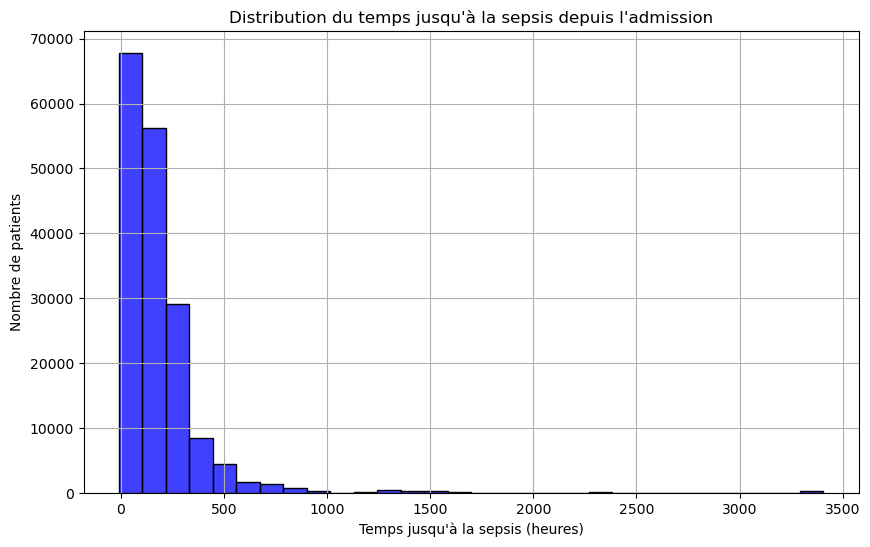

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns
# Créer l'histogramme
plt.figure(figsize=(10, 6))
sns.histplot(df_sepsis['time_to_sepsis'], bins=30, kde=False, color='blue')
plt.title('Distribution du temps jusqu\'à la sepsis depuis l\'admission')
plt.xlabel('Temps jusqu\'à la sepsis (heures)')
plt.ylabel('Nombre de patients')
plt.grid(True)
plt.show()

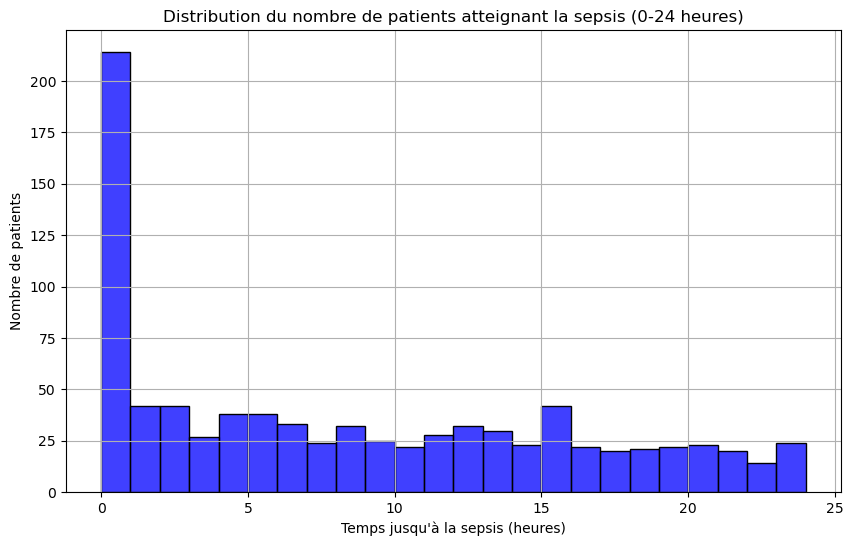

In [140]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrer pour obtenir uniquement les patients qui ont développé une sepsis et dont le temps jusqu'à la sepsis est entre 0 et 24 heures
df_sepsis = df_augm[(df_augm['will_have_sepsis'] == 1) & (df_augm['time_to_sepsis'] >= 0) & (df_augm['time_to_sepsis'] <= 24)]

# Agréger les données pour obtenir le temps minimal jusqu'à la sepsis pour chaque patient unique
df_sepsis_min_time = df_sepsis.groupby('Patient_ID')['time_to_sepsis'].min().reset_index()

# Créer l'histogramme en utilisant la série agrégée
plt.figure(figsize=(10, 6))
sns.histplot(df_sepsis_min_time['time_to_sepsis'], bins=24, kde=False, color='blue')  # bins correspond au nombre d'heures dans une journée
plt.title('Distribution du nombre de patients atteignant la sepsis (0-24 heures)')
plt.xlabel('Temps jusqu\'à la sepsis (heures)')
plt.ylabel('Nombre de patients')
plt.grid(True)
plt.show()

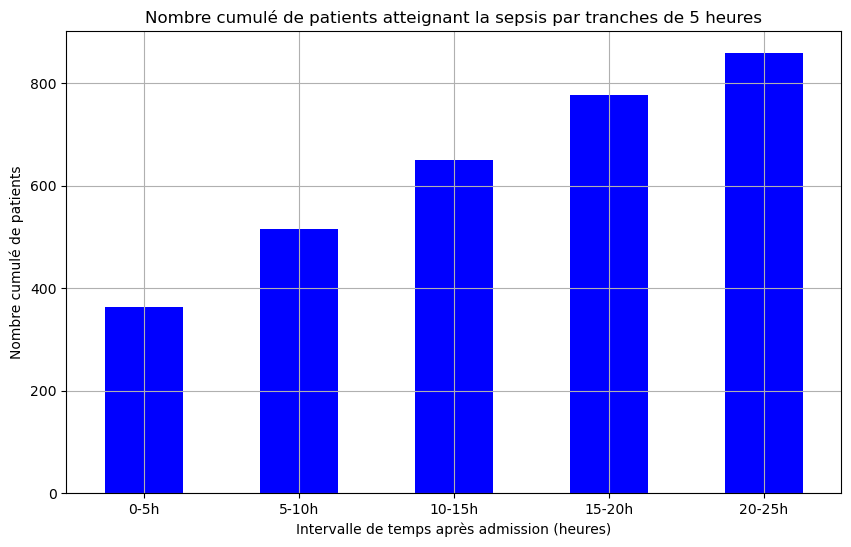

In [141]:
# Agréger les données pour obtenir le temps minimal jusqu'à la sepsis pour chaque patient unique
df_sepsis_min_time = df_sepsis.groupby('Patient_ID')['time_to_sepsis'].min().reset_index()

# Définir les intervalles de 5 heures
bins = [0, 5, 10, 15, 20, 25]

# Créer une nouvelle colonne pour les tranches horaires
df_sepsis_min_time['time_interval'] = pd.cut(df_sepsis_min_time['time_to_sepsis'], bins, right=False, labels=["0-5h", "5-10h", "10-15h", "15-20h", "20-25h"])

# Compter les patients dans chaque intervalle
interval_counts = df_sepsis_min_time['time_interval'].value_counts().sort_index()

# Calculer les cumuls pour chaque intervalle
cumulative_counts = interval_counts.cumsum()

# Créer l'histogramme cumulatif
plt.figure(figsize=(10, 6))
cumulative_counts.plot(kind='bar', color='blue')
plt.title('Nombre cumulé de patients atteignant la sepsis par tranches de 5 heures')
plt.xlabel('Intervalle de temps après admission (heures)')
plt.ylabel('Nombre cumulé de patients')
plt.xticks(rotation=0)  # Ajuster l'orientation des labels de l'axe x si nécessaire
plt.grid(True)
plt.show()

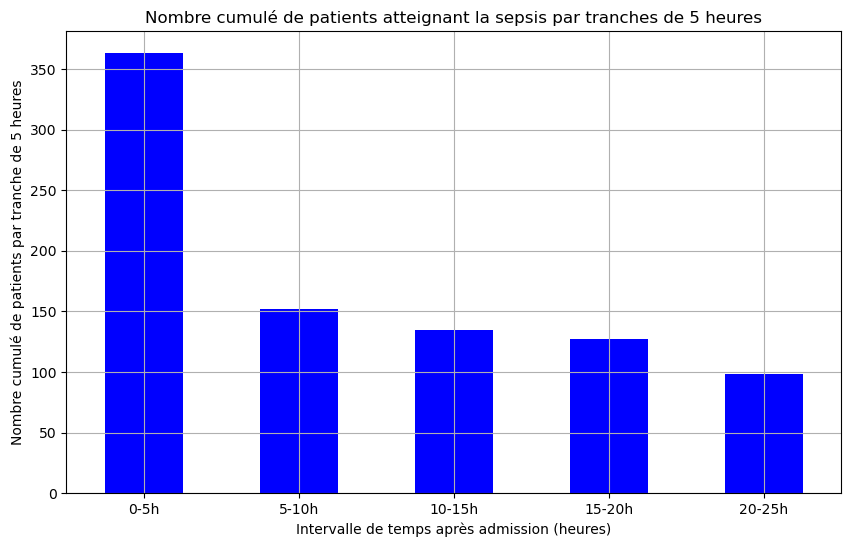

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Agréger les données pour obtenir le temps minimal jusqu'à la sepsis pour chaque patient unique
df_sepsis_min_time = df_sepsis.groupby('Patient_ID')['time_to_sepsis'].min().reset_index()

# Définir les intervalles de 5 heures
bins = [0, 5, 10, 15, 20, 25]

# Créer une nouvelle colonne pour les tranches horaires
df_sepsis_min_time['time_interval'] = pd.cut(df_sepsis_min_time['time_to_sepsis'], bins, right=False, labels=["0-5h", "5-10h", "10-15h", "15-20h", "20-25h"])

# Compter les patients dans chaque intervalle
interval_counts = df_sepsis_min_time['time_interval'].value_counts().sort_index()

# Calculer les cumuls pour chaque intervalle de manière indépendante
# Cela implique de recalculer les cumuls pour chaque bin comme une somme des bins précédents uniquement
cumulative_counts = interval_counts.cumsum() - interval_counts.cumsum().shift(1).fillna(0)

# Créer l'histogramme cumulatif
plt.figure(figsize=(10, 6))
cumulative_counts.plot(kind='bar', color='blue')
plt.title('Nombre cumulé de patients atteignant la sepsis par tranches de 5 heures')
plt.xlabel('Intervalle de temps après admission (heures)')
plt.ylabel('Nombre cumulé de patients par tranche de 5 heures')
plt.xticks(rotation=0)  # Ajuster l'orientation des labels de l'axe x si nécessaire
plt.grid(True)
plt.show()


In [8]:
df_with_time_to_sepsis = add_time_to_sepsis_column(df)
df_with_time_to_sepsis

,Patient_ID,HospAdmTime,Age,Gender,Hour,HR,O2Sat,Temp,SBP,MAP,...,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,ICULOS,SepsisLabel,will_have_sepsis,time_to_sepsis
0,1,-0.03,83.14,0,0,97.0,95.0,36.11,98.0,75.330,...,37.2,12.5,30.5,5.7,124.0,317.0,1,0,0,NaN
1,1,-0.03,83.14,0,1,97.0,95.0,36.11,98.0,75.330,...,37.2,12.5,30.5,5.7,124.0,317.0,2,0,0,NaN
2,1,-0.03,83.14,0,2,89.0,99.0,36.11,122.0,86.000,...,37.2,12.5,30.5,5.7,124.0,317.0,3,0,0,NaN
3,1,-0.03,83.14,0,3,90.0,95.0,36.11,122.0,88.665,...,37.2,12.5,30.5,5.7,124.0,317.0,4,0,0,NaN
4,1,-0.03,83.14,0,4,103.0,88.5,36.11,122.0,91.330,...,37.2,12.5,30.5,5.7,124.0,317.0,5,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1538126,120000,0.00,62.00,0,30,80.0,96.0,36.45,115.0,87.000,...,37.1,11.6,29.1,5.4,289.0,216.0,31,0,0,NaN
1538127,120000,0.00,62.00,0,31,74.0,97.0,36.50,114.0,83.000,...,37.1,11.6,29.1,5.4,289.0,216.0,32,0,0,NaN
1538128,120000,0.00,62.00,0,32,78.0,98.0,36.55,110.0,83.000,...,37.1,11.6,29.1,5.4,289.0,216.0,33,0,0,NaN
1538129,120000,0.00,62.00,0,33,82.0,99.0,36.60,124.0,91.000,...,37.1,11.6,29.1,5.4,289.0,216.0,34,0,0,NaN


(1538131, 43)
40336


,Patient_ID,HospAdmTime,Age,Gender,Hour,HR,O2Sat,Temp,SBP,MAP,...,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,ICULOS,SepsisLabel,will_have_sepsis,time_to_sepsis
0,1,-0.03,83.14,0,0,97.0,95.0,36.11,98.0,75.330,...,37.2,12.5,30.5,5.7,124.0,317.0,1,0,0,NaN
1,1,-0.03,83.14,0,1,97.0,95.0,36.11,98.0,75.330,...,37.2,12.5,30.5,5.7,124.0,317.0,2,0,0,NaN
2,1,-0.03,83.14,0,2,89.0,99.0,36.11,122.0,86.000,...,37.2,12.5,30.5,5.7,124.0,317.0,3,0,0,NaN
3,1,-0.03,83.14,0,3,90.0,95.0,36.11,122.0,88.665,...,37.2,12.5,30.5,5.7,124.0,317.0,4,0,0,NaN
4,1,-0.03,83.14,0,4,103.0,88.5,36.11,122.0,91.330,...,37.2,12.5,30.5,5.7,124.0,317.0,5,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1538126,120000,0.00,62.00,0,30,80.0,96.0,36.45,115.0,87.000,...,37.1,11.6,29.1,5.4,289.0,216.0,31,0,0,NaN
1538127,120000,0.00,62.00,0,31,74.0,97.0,36.50,114.0,83.000,...,37.1,11.6,29.1,5.4,289.0,216.0,32,0,0,NaN
1538128,120000,0.00,62.00,0,32,78.0,98.0,36.55,110.0,83.000,...,37.1,11.6,29.1,5.4,289.0,216.0,33,0,0,NaN
1538129,120000,0.00,62.00,0,33,82.0,99.0,36.60,124.0,91.000,...,37.1,11.6,29.1,5.4,289.0,216.0,34,0,0,NaN


In [9]:
df_filtered = filter_rows_by_time_to_sepsis_min(df_with_time_to_sepsis)
df_filtered

,Patient_ID,HospAdmTime,Age,Gender,Hour,HR,O2Sat,Temp,SBP,MAP,...,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,ICULOS,SepsisLabel,will_have_sepsis,time_to_sepsis
0,1,-0.03,83.14,0,0,97.0,95.0,36.11,98.0,75.330,...,37.2,12.5,30.5,5.7,124.0,317.0,1,0,0,NaN
1,1,-0.03,83.14,0,1,97.0,95.0,36.11,98.0,75.330,...,37.2,12.5,30.5,5.7,124.0,317.0,2,0,0,NaN
2,1,-0.03,83.14,0,2,89.0,99.0,36.11,122.0,86.000,...,37.2,12.5,30.5,5.7,124.0,317.0,3,0,0,NaN
3,1,-0.03,83.14,0,3,90.0,95.0,36.11,122.0,88.665,...,37.2,12.5,30.5,5.7,124.0,317.0,4,0,0,NaN
4,1,-0.03,83.14,0,4,103.0,88.5,36.11,122.0,91.330,...,37.2,12.5,30.5,5.7,124.0,317.0,5,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1538126,120000,0.00,62.00,0,30,80.0,96.0,36.45,115.0,87.000,...,37.1,11.6,29.1,5.4,289.0,216.0,31,0,0,NaN
1538127,120000,0.00,62.00,0,31,74.0,97.0,36.50,114.0,83.000,...,37.1,11.6,29.1,5.4,289.0,216.0,32,0,0,NaN
1538128,120000,0.00,62.00,0,32,78.0,98.0,36.55,110.0,83.000,...,37.1,11.6,29.1,5.4,289.0,216.0,33,0,0,NaN
1538129,120000,0.00,62.00,0,33,82.0,99.0,36.60,124.0,91.000,...,37.1,11.6,29.1,5.4,289.0,216.0,34,0,0,NaN


In [13]:
df_balanced = balance_classes(df_filtered, 'will_have_sepsis')
display_basic_info(df_balanced)

Shape of the DataFrame: (260830, 43)

Numbre of unique patients : 37358

Lignes classes counts :  SepsisLabel
0    260830
Name: count, dtype: int64

Classes counts :  will_have_sepsis
0    130415
1    130415
Name: count, dtype: int64

Columns in the DataFrame: Index(['Patient_ID', 'HospAdmTime', 'Age', 'Gender', 'Hour', 'HR', 'O2Sat',
       'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess', 'HCO3',
       'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos', 'Calcium',
       'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose', 'Lactate',
       'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total', 'TroponinI',
       'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'ICULOS',
       'SepsisLabel', 'will_have_sepsis', 'time_to_sepsis'],
      dtype='object')

Data Types:
 Patient_ID            int64
HospAdmTime         float64
Age                 float64
Gender                int64
Hour                  int64
HR                  float64
O2Sat              

'Descriptive Statistics:'

,Patient_ID,HospAdmTime,Age,Gender,Hour,HR,O2Sat,Temp,SBP,MAP,...,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,ICULOS,SepsisLabel,will_have_sepsis
count,260830.000000,260830.000000,260830.000000,260830.000000,260830.000000,260830.000000,260830.000000,260830.000000,260830.000000,260830.000000,...,260830.000000,260830.000000,260830.000000,260830.000000,260830.000000,260830.000000,260830.000000,260830.000000,260830.0,260830.000000
mean,55186.310996,-67.001992,62.141887,0.571943,40.559334,85.652934,97.226658,36.934697,123.978069,82.553389,...,6.688761,31.212289,10.423690,37.499477,11.511740,314.243329,201.109939,42.130457,0.0,0.500000
std,49992.156999,193.998348,16.257598,0.494798,45.849387,17.851285,3.083193,0.731988,23.564080,16.118475,...,14.188696,5.419636,1.888374,23.483845,6.261812,161.611079,104.896377,45.945009,0.0,0.500001
min,1.000000,-5366.860000,14.000000,0.000000,0.000000,20.000000,20.000000,26.093333,20.000000,20.000000,...,0.010000,9.300000,2.600000,16.762500,0.100000,35.000000,1.000000,1.000000,0.0,0.000000
25%,9322.000000,-53.877500,52.000000,0.000000,11.000000,73.000000,96.000000,36.470000,107.000000,71.000000,...,0.120000,27.368421,9.100000,27.300000,7.862500,200.000000,130.000000,13.000000,0.0,0.000000
50%,18707.000000,-5.270000,64.190000,1.000000,26.000000,84.000000,98.000000,36.900000,122.000000,81.000000,...,0.900000,30.585714,10.200000,30.751684,10.600000,274.000000,185.857143,27.000000,0.0,0.500000
75%,108954.000000,-0.030000,74.000000,1.000000,48.000000,97.000000,99.500000,37.400000,139.000000,92.000000,...,6.568411,34.600000,11.600000,37.400000,13.934783,385.000000,250.000000,50.000000,0.0,1.000000
max,120000.000000,23.990000,100.000000,1.000000,332.000000,223.000000,100.000000,41.600000,299.000000,298.000000,...,440.000000,70.200000,30.000000,250.000000,343.000000,1760.000000,2322.000000,336.000000,0.0,1.000000



Missing Values Per Column:
 Patient_ID               0
HospAdmTime              0
Age                      0
Gender                   0
Hour                     0
HR                       0
O2Sat                    0
Temp                     0
SBP                      0
MAP                      0
DBP                      0
Resp                     0
EtCO2                    0
BaseExcess               0
HCO3                     0
FiO2                     0
pH                       0
PaCO2                    0
SaO2                     0
AST                      0
BUN                      0
Alkalinephos             0
Calcium                  0
Chloride                 0
Creatinine               0
Bilirubin_direct         0
Glucose                  0
Lactate                  0
Magnesium                0
Phosphate                0
Potassium                0
Bilirubin_total          0
TroponinI                0
Hct                      0
Hgb                      0
PTT                      0

'First 5 Rows of the DataFrame:'

,Patient_ID,HospAdmTime,Age,Gender,Hour,HR,O2Sat,Temp,SBP,MAP,...,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,ICULOS,SepsisLabel,will_have_sepsis,time_to_sepsis
924686,103826,-2.03,57.00,0,26,65.0,99.0,37.107692,98.0,65.0,...,26.400000,7.800,29.8,11.00,235.0,339.00,27,0,0,NaN
385036,10026,-185.19,72.89,0,16,85.0,95.0,37.300000,132.0,72.0,...,26.830769,9.700,28.2,9.00,254.0,117.00,19,0,0,NaN
571105,14912,-2.84,80.33,0,38,73.0,97.0,36.415000,101.0,52.0,...,33.436000,11.348,26.7,16.12,296.0,119.56,39,0,0,NaN
308007,8036,-18.17,62.20,1,33,81.0,93.0,36.833333,102.0,68.0,...,23.300000,8.500,33.3,5.00,173.0,160.00,37,0,0,NaN
650049,16967,-3.53,83.50,1,22,75.0,96.0,36.780000,129.0,68.0,...,29.800000,10.400,27.5,14.20,340.0,187.00,23,0,0,NaN


In [15]:
# df_balanced.to_csv('df_final_filtered_balanced.csv', index=False)

# Lstm

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [43]:
# Préparation des données
def preprocess_data(df, scaler=None):
    
    # Transformation de la colonne catégorielle Gender
    df = pd.get_dummies(df, columns=['Gender'], drop_first=True)
    
    # Normalisation des colonnes d'intérêt
    columns_normalized = ['MAP', 'BUN', 'Creatinine', 'Glucose', 'WBC', 'Platelets']
    for col in columns_normalized:
        df[col] = np.log(df[col] + 1)
    
    # Isoler les labels avant la normalisation
    labels = df['will_have_sepsis']

    # Supprimer les colonnes non nécessaires
#     df = df.drop(['SepsisLabel', 'will_have_sepsis', 'time_to_sepsis'], axis=1)
    
    # Normalisation des données
    if scaler is None:
        scaler = StandardScaler()
        df[df.columns] = scaler.fit_transform(df[df.columns])
    else:
        df[df.columns] = scaler.transform(df[df.columns])
        
    # Réintégrer les labels après la normalisation
    df['will_have_sepsis'] = labels
    
    return df, scaler



In [44]:
# Appliquer la fonction preprocess_data sur les ensembles d'entraînement et de test
df_processed, scaler = preprocess_data(df_balanced)
# df_test, _ = preprocess_data(df_test_4_8, scaler)


In [21]:
display_basic_info(df_processed)

Shape of the DataFrame: (260830, 41)

Numbre of unique patients : 37358

Classes counts :  will_have_sepsis
0    130415
1    130415
Name: count, dtype: int64

Columns in the DataFrame: Index(['Patient_ID', 'HospAdmTime', 'Age', 'Hour', 'HR', 'O2Sat', 'Temp',
       'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess', 'HCO3', 'FiO2',
       'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos', 'Calcium',
       'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose', 'Lactate',
       'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total', 'TroponinI',
       'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'ICULOS',
       'Gender_1', 'will_have_sepsis'],
      dtype='object')

Data Types:
 Patient_ID          float64
HospAdmTime         float64
Age                 float64
Hour                float64
HR                  float64
O2Sat               float64
Temp                float64
SBP                 float64
MAP                 float64
DBP                 float64
Resp          

'Descriptive Statistics:'

,Patient_ID,HospAdmTime,Age,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,...,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,ICULOS,Gender_1,will_have_sepsis
count,2.608300e+05,2.608300e+05,2.608300e+05,2.608300e+05,2.608300e+05,2.608300e+05,2.608300e+05,2.608300e+05,2.608300e+05,2.608300e+05,...,2.608300e+05,2.608300e+05,2.608300e+05,2.608300e+05,2.608300e+05,2.608300e+05,2.608300e+05,2.608300e+05,2.608300e+05,260830.000000
mean,-3.486925e-17,-4.266035e-17,3.935867e-16,7.845582e-17,1.176837e-16,-8.625781e-16,9.196765e-15,-5.289230e-16,-1.624907e-15,3.181819e-16,...,1.080947e-16,2.164073e-16,1.463637e-15,5.657536e-16,-6.333128e-16,6.004049e-17,6.093402e-16,3.312579e-17,-7.496889e-17,0.500000
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,...,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,0.500001
min,-1.103881e+00,-2.731914e+01,-2.961199e+00,-8.846228e-01,-3.677778e+00,-2.504767e+01,-1.481088e+01,-4.412575e+00,-7.228358e+00,-3.024148e+00,...,-4.707109e-01,-4.043137e+00,-4.143091e+00,-8.830333e-01,-5.439044e+00,-1.727876e+00,-8.205426e+00,-8.952123e-01,-1.155915e+00,0.000000
25%,-9.174319e-01,6.765273e-02,-6.238256e-01,-6.447063e-01,-7.087982e-01,-3.978539e-01,-6.348438e-01,-7.205077e-01,-6.944118e-01,-6.462189e-01,...,-4.629582e-01,-7.092498e-01,-7.009693e-01,-4.343197e-01,-5.891318e-01,-7.069042e-01,-5.470730e-01,-6.340300e-01,-1.155915e+00,0.000000
50%,-7.297021e-01,3.182095e-01,1.259791e-01,-3.175476e-01,-9.259487e-02,2.508255e-01,-4.740145e-02,-8.394442e-02,-4.751913e-03,-1.216756e-01,...,-4.079848e-01,-1.156122e-01,-1.184565e-01,-2.873382e-01,3.654236e-02,-2.490139e-01,1.032877e-01,-3.293173e-01,8.651154e-01,0.500000
75%,1.075525e+00,3.452201e-01,7.293904e-01,1.622853e-01,6.356454e-01,7.373351e-01,6.356711e-01,6.374940e-01,6.627796e-01,5.427458e-01,...,-8.482099e-03,6.250821e-01,6.229236e-01,-4.235985e-03,6.238908e-01,4.378215e-01,6.437034e-01,1.712821e-01,8.651154e-01,1.000000
max,1.296480e+00,4.690358e-01,2.328646e+00,6.356491e+00,7.693975e+00,8.995049e-01,6.373480e+00,7.427503e+00,6.855751e+00,1.641892e+01,...,3.053925e+01,7.193802e+00,1.036678e+01,9.048813e+00,7.915426e+00,8.945918e+00,4.718517e+00,6.396127e+00,8.651154e-01,1.000000



Missing Values Per Column:
 Patient_ID          0
HospAdmTime         0
Age                 0
Hour                0
HR                  0
O2Sat               0
Temp                0
SBP                 0
MAP                 0
DBP                 0
Resp                0
EtCO2               0
BaseExcess          0
HCO3                0
FiO2                0
pH                  0
PaCO2               0
SaO2                0
AST                 0
BUN                 0
Alkalinephos        0
Calcium             0
Chloride            0
Creatinine          0
Bilirubin_direct    0
Glucose             0
Lactate             0
Magnesium           0
Phosphate           0
Potassium           0
Bilirubin_total     0
TroponinI           0
Hct                 0
Hgb                 0
PTT                 0
WBC                 0
Fibrinogen          0
Platelets           0
ICULOS              0
Gender_1            0
will_have_sepsis    0
dtype: int64


'First 5 Rows of the DataFrame:'

,Patient_ID,HospAdmTime,Age,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,...,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,ICULOS,Gender_1,will_have_sepsis
924686,0.972948,0.334911,-0.316277,-0.317548,-1.156946,0.575165,0.236336,-1.102446,-1.155825,-0.646219,...,-0.470711,-0.887938,-1.389394,-0.327863,0.115343,-0.490334,1.199472,-0.329317,-1.155915,0
385036,-0.903350,-0.609223,0.661114,-0.535653,-0.036576,-0.722194,0.499057,0.340431,-0.621267,-1.555427,...,1.050926,-0.808454,-0.383235,-0.395995,-0.308446,-0.372768,-0.738461,-0.503439,-1.155915,0
571105,-0.805614,0.330735,1.118748,-0.055821,-0.708798,-0.073514,-0.709982,-0.975133,-2.319086,-1.065853,...,-0.203596,0.410307,0.489475,-0.459869,0.941299,-0.112884,-0.699157,-0.068135,-1.155915,0
308007,-0.943156,0.251714,0.003575,-0.164873,-0.260650,-1.370873,-0.138478,-0.932696,-0.920102,-0.856036,...,2.700129,-1.459933,-1.018704,-0.178824,-1.495811,-0.873972,-0.169458,-0.111665,0.865115,0
650049,-0.764508,0.327179,1.313734,-0.404790,-0.596761,-0.397854,-0.211339,0.213118,-0.920102,-0.646219,...,-0.252931,-0.260588,-0.012545,-0.425803,0.664806,0.159375,0.114454,-0.416378,0.865115,0


In [26]:
# Fonction à revoir 


X_train, X_test, y_train, y_test = prepare_train_test(df_processed, 'will_have_sepsis')
print(X_train)
print(X_test)
print(y_train)
print(y_test)

X_train: (208664, 40) X_test: (52166, 40) y_train: (208664,) y_test: (52166,)
         Patient_ID  HospAdmTime       Age      Hour        HR     O2Sat  \
848043     0.931602    -1.870782  0.298822 -0.862812  0.607636 -1.208703   
924476     0.972828     0.327076 -0.439296 -0.622896 -1.212965  0.575165   
689780    -0.743584     0.186043 -2.044087 -0.841002 -0.092595  0.575165   
640929    -0.769528    -1.485263  0.276063 -0.121252 -0.036576 -0.073514   
539471    -0.822157     0.345220  1.382010 -0.601085 -0.932872 -0.397854   
...             ...          ...       ...       ...       ...       ...   
273564    -0.961079     0.345220  0.107526  1.012898 -1.044909  0.250826   
973327     0.998872     0.216301  0.606371  0.489444 -2.053242  0.250826   
970474     0.997332     0.279240 -0.193257  4.742508 -0.064586  0.737335   
206051    -0.996584     0.345323  0.848719 -0.382979 -0.708798 -0.073514   
1266710    1.152977     0.091970 -0.685335  0.314959  1.980089 -0.722194   

         

In [25]:
print(X_train['Patient_ID'].nunique())
print(X_test['Patient_ID'].nunique())
print(y_train)
print(y_test)

36008
20190
1015716    0
1244737    1
469929     0
701188     1
140865     1
          ..
1348943    0
751214     0
1293023    0
644511     0
1430514    0
Name: will_have_sepsis, Length: 208664, dtype: int64
15292      1
977132     0
554917     0
776260     0
1432100    0
          ..
520532     0
1455820    0
1511088    0
974287     0
801927     0
Name: will_have_sepsis, Length: 52166, dtype: int64


In [54]:
# Séparer les données de manière à ce qu'il n'y ait pas un même patient dans l'ensemble train et test 

# df_train, df_test = split_train_test_data(df_processed)

df_train.to_csv('df_train_full.csv')
df_test.to_csv('df_test_full.csv')

In [28]:
display_basic_info(df_train)

Shape of the DataFrame: (207250, 41)

Numbre of unique patients : 29888

Classes counts :  will_have_sepsis
0    104025
1    103225
Name: count, dtype: int64

Columns in the DataFrame: Index(['Patient_ID', 'HospAdmTime', 'Age', 'Hour', 'HR', 'O2Sat', 'Temp',
       'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess', 'HCO3', 'FiO2',
       'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos', 'Calcium',
       'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose', 'Lactate',
       'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total', 'TroponinI',
       'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'ICULOS',
       'Gender_1', 'will_have_sepsis'],
      dtype='object')

Data Types:
 Patient_ID          float64
HospAdmTime         float64
Age                 float64
Hour                float64
HR                  float64
O2Sat               float64
Temp                float64
SBP                 float64
MAP                 float64
DBP                 float64
Resp          

'Descriptive Statistics:'

,Patient_ID,HospAdmTime,Age,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,...,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,ICULOS,Gender_1,will_have_sepsis
count,207250.000000,207250.000000,207250.000000,207250.000000,207250.000000,207250.000000,207250.000000,207250.000000,207250.000000,207250.000000,...,207250.000000,207250.000000,207250.000000,207250.000000,207250.000000,207250.000000,207250.000000,207250.000000,207250.000000,207250.000000
mean,-0.005886,-0.003642,0.000913,-0.005337,0.012459,0.000380,0.017625,0.003351,0.005078,0.001621,...,-0.018951,-0.000156,0.000678,-0.015756,0.004188,-0.003753,-0.006960,-0.005082,0.006131,0.498070
std,0.998708,1.051773,1.005316,0.999500,1.001095,1.008033,1.000899,0.998169,0.998385,1.000611,...,0.962019,1.007481,1.003512,0.950525,0.995580,0.994722,1.003938,0.999857,0.999092,0.499997
min,-1.103881,-27.319141,-2.961199,-0.884623,-3.677778,-25.047671,-14.810876,-4.370137,-7.103578,-3.024148,...,-0.470711,-4.043137,-4.143091,-0.883033,-5.439044,-1.727876,-8.205426,-0.895212,-1.155915,0.000000
25%,-0.914591,0.078671,-0.623826,-0.644706,-0.708798,-0.397854,-0.621182,-0.720508,-0.694412,-0.646219,...,-0.462958,-0.720875,-0.700969,-0.434320,-0.585856,-0.706904,-0.547073,-0.634030,-1.155915,0.000000
50%,-0.730642,0.319807,0.114292,-0.339358,-0.036576,0.250826,-0.047401,-0.083944,-0.004752,-0.086706,...,-0.407280,-0.119379,-0.116154,-0.286497,0.042001,-0.249014,0.094868,-0.329317,0.865115,0.000000
75%,1.073424,0.345220,0.729390,0.162285,0.663655,0.791392,0.635671,0.637494,0.662780,0.542746,...,-0.020352,0.634254,0.622924,-0.004236,0.633345,0.437822,0.640052,0.149517,0.865115,1.000000
max,1.296480,0.458984,2.328646,6.356491,7.693975,0.899505,6.373480,7.427503,6.855751,16.418920,...,30.539245,7.193802,8.566281,9.048813,7.915426,5.765437,4.718517,6.396127,0.865115,1.000000



Missing Values Per Column:
 Patient_ID          0
HospAdmTime         0
Age                 0
Hour                0
HR                  0
O2Sat               0
Temp                0
SBP                 0
MAP                 0
DBP                 0
Resp                0
EtCO2               0
BaseExcess          0
HCO3                0
FiO2                0
pH                  0
PaCO2               0
SaO2                0
AST                 0
BUN                 0
Alkalinephos        0
Calcium             0
Chloride            0
Creatinine          0
Bilirubin_direct    0
Glucose             0
Lactate             0
Magnesium           0
Phosphate           0
Potassium           0
Bilirubin_total     0
TroponinI           0
Hct                 0
Hgb                 0
PTT                 0
WBC                 0
Fibrinogen          0
Platelets           0
ICULOS              0
Gender_1            0
will_have_sepsis    0
dtype: int64


'First 5 Rows of the DataFrame:'

,Patient_ID,HospAdmTime,Age,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,...,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,ICULOS,Gender_1,will_have_sepsis
924686,0.972948,0.334911,-0.316277,-0.317548,-1.156946,0.575165,0.236336,-1.102446,-1.155825,-0.646219,...,-0.470711,-0.887938,-1.389394,-0.327863,0.115343,-0.490334,1.199472,-0.329317,-1.155915,0
385036,-0.903350,-0.609223,0.661114,-0.535653,-0.036576,-0.722194,0.499057,0.340431,-0.621267,-1.555427,...,1.050926,-0.808454,-0.383235,-0.395995,-0.308446,-0.372768,-0.738461,-0.503439,-1.155915,0
571105,-0.805614,0.330735,1.118748,-0.055821,-0.708798,-0.073514,-0.709982,-0.975133,-2.319086,-1.065853,...,-0.203596,0.410307,0.489475,-0.459869,0.941299,-0.112884,-0.699157,-0.068135,-1.155915,0
308007,-0.943156,0.251714,0.003575,-0.164873,-0.260650,-1.370873,-0.138478,-0.932696,-0.920102,-0.856036,...,2.700129,-1.459933,-1.018704,-0.178824,-1.495811,-0.873972,-0.169458,-0.111665,0.865115,0
541605,-0.820957,0.345272,-0.084385,-0.470222,-0.820835,-0.073514,-2.000989,-1.314634,-0.920102,-1.275671,...,-0.288171,1.108175,1.364304,0.587661,0.052880,0.085122,0.144317,-0.481674,0.865115,0


In [49]:
# Trier df_train par patient et hour pour assurer l'ordre temporelle des mesures
df_train_sorted = sort_dataset_by_patient_and_hour(df_train)
display_basic_info(df_train_sorted)

Shape of the DataFrame: (207250, 43)

Numbre of unique patients : 29888

Lignes classes counts :  SepsisLabel
0.0    207250
Name: count, dtype: int64

Classes counts :  will_have_sepsis
0    104025
1    103225
Name: count, dtype: int64

Columns in the DataFrame: Index(['Patient_ID', 'HospAdmTime', 'Age', 'Hour', 'HR', 'O2Sat', 'Temp',
       'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess', 'HCO3', 'FiO2',
       'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos', 'Calcium',
       'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose', 'Lactate',
       'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total', 'TroponinI',
       'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'ICULOS',
       'SepsisLabel', 'will_have_sepsis', 'time_to_sepsis', 'Gender_1'],
      dtype='object')

Data Types:
 Patient_ID          float64
HospAdmTime         float64
Age                 float64
Hour                float64
HR                  float64
O2Sat               float64
Temp           

'Descriptive Statistics:'

,Patient_ID,HospAdmTime,Age,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,...,Hgb,PTT,WBC,Fibrinogen,Platelets,ICULOS,SepsisLabel,will_have_sepsis,time_to_sepsis,Gender_1
count,207250.000000,207250.000000,207250.000000,207250.000000,207250.000000,207250.000000,207250.000000,207250.000000,207250.000000,207250.000000,...,207250.000000,207250.000000,207250.000000,207250.000000,207250.000000,207250.000000,207250.0,207250.000000,103225.000000,207250.000000
mean,-0.005886,-0.003642,0.000913,-0.005337,0.012459,0.000380,0.017625,0.003351,0.005078,0.001621,...,0.000678,-0.015756,0.004188,-0.003753,-0.006960,-0.005082,0.0,0.498070,-0.003149,0.006131
std,0.998708,1.051773,1.005316,0.999500,1.001095,1.008033,1.000899,0.998169,0.998385,1.000611,...,1.003512,0.950525,0.995580,0.994722,1.003938,0.999857,0.0,0.499997,1.005520,0.999092
min,-1.103881,-27.319141,-2.961199,-0.884623,-3.677778,-25.047671,-14.810876,-4.370137,-7.103578,-3.024148,...,-4.143091,-0.883033,-5.439044,-1.727876,-8.205426,-0.895212,0.0,0.000000,-1.077763,-1.155915
25%,-0.914591,0.078671,-0.623826,-0.644706,-0.708798,-0.397854,-0.621182,-0.720508,-0.694412,-0.646219,...,-0.700969,-0.434320,-0.585856,-0.706904,-0.547073,-0.634030,0.0,0.000000,-0.771072,-1.155915
50%,-0.730642,0.319807,0.114292,-0.339358,-0.036576,0.250826,-0.047401,-0.083944,-0.004752,-0.086706,...,-0.116154,-0.286497,0.042001,-0.249014,0.094868,-0.329317,0.0,0.000000,-0.320056,0.865115
75%,1.073424,0.345220,0.729390,0.162285,0.663655,0.791392,0.635671,0.637494,0.662780,0.542746,...,0.622924,-0.004236,0.633345,0.437822,0.640052,0.149517,0.0,1.000000,0.473731,0.865115
max,1.296480,0.458984,2.328646,6.356491,7.693975,0.899505,6.373480,7.427503,6.855751,16.418920,...,8.566281,9.048813,7.915426,5.765437,4.718517,6.396127,0.0,1.000000,4.749360,0.865115



Missing Values Per Column:
 Patient_ID               0
HospAdmTime              0
Age                      0
Hour                     0
HR                       0
O2Sat                    0
Temp                     0
SBP                      0
MAP                      0
DBP                      0
Resp                     0
EtCO2                    0
BaseExcess               0
HCO3                     0
FiO2                     0
pH                       0
PaCO2                    0
SaO2                     0
AST                      0
BUN                      0
Alkalinephos             0
Calcium                  0
Chloride                 0
Creatinine               0
Bilirubin_direct         0
Glucose                  0
Lactate                  0
Magnesium                0
Phosphate                0
Potassium                0
Bilirubin_total          0
TroponinI                0
Hct                      0
Hgb                      0
PTT                      0
WBC                      0

'First 5 Rows of the DataFrame:'

,Patient_ID,HospAdmTime,Age,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,...,Hgb,PTT,WBC,Fibrinogen,Platelets,ICULOS,SepsisLabel,will_have_sepsis,time_to_sepsis,Gender_1
9,-1.103881,0.34522,1.29159,-0.688328,0.915738,-2.019552,-0.040571,0.425306,0.389575,-1.415549,...,1.099525,-0.298056,-1.239317,-1.17717,1.076973,-0.699326,0.0,0,NaN,-1.155915
19,-1.103881,0.34522,1.29159,-0.470222,1.307867,-2.019552,0.239489,0.976994,0.605450,-1.415549,...,1.078803,-0.298056,-0.864048,-1.17717,1.092679,-0.481674,0.0,0,NaN,-1.155915
21,-1.103881,0.34522,1.29159,-0.426600,0.691664,-1.370873,-0.061063,0.425306,0.143827,-1.415549,...,1.064989,-0.298056,-0.643792,-1.17717,1.103075,-0.438143,0.0,0,NaN,-1.155915
22,-1.103881,0.34522,1.29159,-0.404790,0.803701,-3.965591,-0.211339,0.382869,0.469123,-1.415549,...,1.058081,-0.298056,-0.541027,-1.17717,1.108251,-0.416378,0.0,0,NaN,-1.155915
30,-1.103881,0.34522,1.29159,-0.230305,1.335876,-2.343892,0.369273,1.061870,1.617007,-1.415549,...,1.002823,-0.298056,0.149618,-1.17717,1.149142,-0.242257,0.0,0,NaN,-1.155915


In [46]:
display_basic_info(df_test)

Shape of the DataFrame: (53580, 43)

Numbre of unique patients : 7470

Lignes classes counts :  SepsisLabel
0.0    53580
Name: count, dtype: int64

Classes counts :  will_have_sepsis
1    27190
0    26390
Name: count, dtype: int64

Columns in the DataFrame: Index(['Patient_ID', 'HospAdmTime', 'Age', 'Hour', 'HR', 'O2Sat', 'Temp',
       'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess', 'HCO3', 'FiO2',
       'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos', 'Calcium',
       'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose', 'Lactate',
       'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total', 'TroponinI',
       'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'ICULOS',
       'SepsisLabel', 'will_have_sepsis', 'time_to_sepsis', 'Gender_1'],
      dtype='object')

Data Types:
 Patient_ID          float64
HospAdmTime         float64
Age                 float64
Hour                float64
HR                  float64
O2Sat               float64
Temp                

'Descriptive Statistics:'

,Patient_ID,HospAdmTime,Age,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,...,Hgb,PTT,WBC,Fibrinogen,Platelets,ICULOS,SepsisLabel,will_have_sepsis,time_to_sepsis,Gender_1
count,53580.000000,53580.000000,53580.000000,53580.000000,53580.000000,53580.000000,53580.000000,53580.000000,53580.000000,53580.000000,...,53580.000000,53580.000000,53580.000000,53580.000000,53580.000000,53580.000000,53580.0,53580.000000,27190.000000,53580.000000
mean,0.022768,0.014087,-0.003530,0.020644,-0.048193,-0.001471,-0.068175,-0.012961,-0.019640,-0.006271,...,-0.002621,0.060947,-0.016198,0.014518,0.026923,0.019659,0.0,0.507465,0.011956,-0.023716
std,1.004678,0.767391,0.979177,1.001683,0.994302,0.968320,0.993593,1.006965,1.006001,0.997628,...,0.986310,1.169891,1.016773,1.020046,0.984176,1.000329,0.0,0.499949,0.978705,1.003171
min,-1.103741,-16.505832,-2.838179,-0.884623,-3.621759,-25.047671,-14.023065,-4.412575,-7.228358,-3.024148,...,-3.295799,-0.851629,-5.439044,-1.727876,-8.205426,-0.895212,0.0,0.000000,-1.077763,-1.155915
25%,-0.925493,0.010474,-0.603220,-0.622896,-0.764817,-0.397854,-0.675828,-0.762945,-0.694412,-0.681188,...,-0.700969,-0.434320,-0.598988,-0.700716,-0.527177,-0.634030,0.0,0.000000,-0.753031,-1.155915
50%,-0.724401,0.312694,0.175802,-0.317548,-0.092595,0.250826,-0.064478,-0.126382,-0.026136,-0.156645,...,-0.118456,-0.289539,0.016418,-0.218075,0.129878,-0.307552,0.0,1.000000,-0.265934,0.865115
75%,1.087711,0.345220,0.729390,0.205906,0.579627,0.656250,0.546872,0.637494,0.662780,0.542746,...,0.600228,-0.000822,0.601640,0.431634,0.665765,0.214813,0.0,1.000000,0.491772,0.865115
max,1.296380,0.469036,2.328646,6.356491,4.388884,0.899505,5.963637,6.451439,6.855751,15.160017,...,10.366776,9.048813,6.883835,8.945918,3.716443,6.330831,0.0,1.000000,4.586994,0.865115



Missing Values Per Column:
 Patient_ID              0
HospAdmTime             0
Age                     0
Hour                    0
HR                      0
O2Sat                   0
Temp                    0
SBP                     0
MAP                     0
DBP                     0
Resp                    0
EtCO2                   0
BaseExcess              0
HCO3                    0
FiO2                    0
pH                      0
PaCO2                   0
SaO2                    0
AST                     0
BUN                     0
Alkalinephos            0
Calcium                 0
Chloride                0
Creatinine              0
Bilirubin_direct        0
Glucose                 0
Lactate                 0
Magnesium               0
Phosphate               0
Potassium               0
Bilirubin_total         0
TroponinI               0
Hct                     0
Hgb                     0
PTT                     0
WBC                     0
Fibrinogen              0
Platelets

'First 5 Rows of the DataFrame:'

,Patient_ID,HospAdmTime,Age,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,...,Hgb,PTT,WBC,Fibrinogen,Platelets,ICULOS,SepsisLabel,will_have_sepsis,time_to_sepsis,Gender_1
650049,-0.764508,0.327179,1.313734,-0.404790,-0.596761,-0.397854,-0.211339,0.213118,-0.920102,-0.646219,...,-0.012545,-0.425803,0.664806,0.159375,0.114454,-0.416378,0.0,0,NaN,0.865115
166391,-1.017248,0.345272,0.268067,0.053232,0.747682,-0.397854,0.089213,0.043368,1.152627,-0.576280,...,1.152481,-0.485419,0.172739,1.718677,1.128081,0.040691,0.0,0,NaN,0.865115
1351559,1.198004,-1.539336,0.852410,-0.819191,-0.092595,0.899505,-0.457245,1.316495,0.775612,-0.296523,...,-1.124615,-0.395995,-0.262416,-0.211888,2.060164,-0.829917,0.0,0,NaN,-1.155915
531265,-0.826117,-1.183971,0.673416,-0.186684,0.299535,0.250826,0.164351,-0.211257,-0.549118,1.731710,...,0.035597,-0.332122,-0.372719,0.635828,1.100381,-0.198726,0.0,0,NaN,0.865115
669565,-0.754246,0.341973,0.664190,-0.731949,-0.260650,0.899505,0.280473,0.170681,0.247815,-0.086706,...,-0.648014,-0.166050,-1.345797,-0.576962,0.055057,-0.742856,0.0,0,NaN,-1.155915


In [50]:
X_train = df_train_sorted.drop(['SepsisLabel', 'will_have_sepsis', 'time_to_sepsis'], axis=1).values
# X_test = df_test.drop('will_have_sepsis', axis=1).values
y_train = df_train_sorted['will_have_sepsis'].values
# y_test = df_test['will_have_sepsis'].values

In [51]:
# Reshape des données pour LSTM (échantillons, séquences, caractéristiques)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
# X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Encodage one-hot des labels
y_train = to_categorical(y_train, num_classes=2)
# y_test = to_categorical(y_test, num_classes=2)


In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Définition du modèle LSTM
model = Sequential()

# Ajout d'une première couche LSTM avec 64 neurones et input_shape adapté à vos données
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Ajout d'une deuxième couche LSTM avec 32 neurones
model.add(LSTM(units=32))
model.add(Dropout(0.2))

# Couche Dense pour la classification binaire avec activation softmax
model.add(Dense(units=2, activation='softmax'))

# Compilation du modèle avec optimiseur Adam et fonction de perte categorical_crossentropy
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Affichage de l'architecture du modèle
model.summary()


C:\Users\AdminPC\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 1, 64)               │          26,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,362 (153.76 KB)

 Trainable params: 39,362 (153.76 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Entraînement du modèle avec X_train et y_train
history = model.fit(X_train, y_train, epochs=20, batch_size=128, validation_data=(X_test, y_test), verbose=1)

# Évaluation du modèle sur les données de test
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Epoch 1/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.7198 - loss: 0.5388 - val_accuracy: 0.7293 - val_loss: 0.5388
Epoch 2/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7674 - loss: 0.4589 - val_accuracy: 0.7272 - val_loss: 0.5719
Epoch 3/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7819 - loss: 0.4336 - val_accuracy: 0.7183 - val_loss: 0.6180
Epoch 4/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7939 - loss: 0.4143 - val_accuracy: 0.7174 - val_loss: 0.6522
Epoch 5/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8020 - loss: 0.3994 - val_accuracy: 0.7124 - val_loss: 0.6941
Epoch 6/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8106 - loss: 0.3841 - val_accuracy: 0.7106 - val_loss: 0.7101
Epoch 7/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8183 - loss: 0.3735 - val_accuracy: 0.7088 - val_loss: 0.7491
Epoch 8/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8259 - loss: 0.3583 -

In [38]:
# Évaluation du modèle
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes))

1675/1675 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
              precision    recall  f1-score   support

           0       0.63      0.86      0.73     26390
           1       0.79      0.51      0.62     27190

    accuracy                           0.68     53580
   macro avg       0.71      0.69      0.68     53580
weighted avg       0.71      0.68      0.67     53580



In [62]:
# On refait l'exécution après le trie de l'ensemble test

df = pd.read_csv('df_final_filtered_balanced.csv')

df

,Patient_ID,HospAdmTime,Age,Gender,Hour,HR,O2Sat,Temp,SBP,MAP,...,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,ICULOS,SepsisLabel,will_have_sepsis,time_to_sepsis
0,103826,-2.03,57.00,0,26,65.0,99.000000,37.107692,98.000000,65.0,...,26.400000,7.800,29.8,11.00,235.0,339.00,27,0,0,NaN
1,10026,-185.19,72.89,0,16,85.0,95.000000,37.300000,132.000000,72.0,...,26.830769,9.700,28.2,9.00,254.0,117.00,19,0,0,NaN
2,14912,-2.84,80.33,0,38,73.0,97.000000,36.415000,101.000000,52.0,...,33.436000,11.348,26.7,16.12,296.0,119.56,39,0,0,NaN
3,8036,-18.17,62.20,1,33,81.0,93.000000,36.833333,102.000000,68.0,...,23.300000,8.500,33.3,5.00,173.0,160.00,37,0,0,NaN
4,16967,-3.53,83.50,1,22,75.0,96.000000,36.780000,129.000000,68.0,...,29.800000,10.400,27.5,14.20,340.0,187.00,23,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260825,119959,-321.03,56.00,0,20,95.0,95.714286,37.191667,114.666667,86.0,...,28.600000,8.320,37.0,10.30,250.0,295.20,21,0,1,11.0
260826,119959,-321.03,56.00,0,21,105.0,95.571429,37.333333,111.333333,86.0,...,28.525000,8.305,37.0,10.45,250.0,294.05,22,0,1,10.0
260827,119959,-321.03,56.00,0,22,115.0,95.428571,37.475000,108.000000,86.0,...,28.450000,8.290,37.0,10.60,250.0,292.90,23,0,1,9.0
260828,119959,-321.03,56.00,0,23,106.0,95.285714,37.616667,120.000000,95.0,...,28.375000,8.275,37.0,10.75,250.0,291.75,24,0,1,8.0


In [63]:
df_train, df_test = split_train_test_data(df)

df_train.to_csv('df_train_full.csv')
df_test.to_csv('df_test_full.csv')

In [64]:

df_test_sorted = sort_dataset_by_patient_and_hour(df_test)

df_train_sorted = sort_dataset_by_patient_and_hour(df_train)

df_train_sorted.to_csv('df_train_sorted.csv',index=False)
df_test_sorted.to_csv('df_test_sorted.csv',index=False)


df_test_filtred_6_12 = filter_rows_by_time_to_sepsis(df_test_sorted)

In [65]:
display_basic_info(df_train_sorted)

Shape of the DataFrame: (207250, 43)

Numbre of unique patients : 29888

Lignes classes counts :  SepsisLabel
0    207250
Name: count, dtype: int64

Classes counts :  will_have_sepsis
0    104025
1    103225
Name: count, dtype: int64

Columns in the DataFrame: Index(['Patient_ID', 'HospAdmTime', 'Age', 'Gender', 'Hour', 'HR', 'O2Sat',
       'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess', 'HCO3',
       'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos', 'Calcium',
       'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose', 'Lactate',
       'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total', 'TroponinI',
       'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'ICULOS',
       'SepsisLabel', 'will_have_sepsis', 'time_to_sepsis'],
      dtype='object')

Data Types:
 Patient_ID            int64
HospAdmTime         float64
Age                 float64
Gender                int64
Hour                  int64
HR                  float64
O2Sat              

'Descriptive Statistics:'

,Patient_ID,HospAdmTime,Age,Gender,Hour,HR,O2Sat,Temp,SBP,MAP,...,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,ICULOS,SepsisLabel,will_have_sepsis,time_to_sepsis
count,207250.000000,207250.000000,207250.000000,207250.000000,207250.000000,207250.000000,207250.000000,207250.000000,207250.000000,207250.000000,...,207250.000000,207250.000000,207250.000000,207250.000000,207250.000000,207250.000000,207250.000000,207250.0,207250.000000,103225.000000
mean,54892.052970,-67.708508,62.156726,0.574977,40.314630,85.875346,97.227831,36.947599,124.057027,82.628125,...,31.211443,10.424969,37.129455,11.529384,313.636762,200.566682,41.896951,0.0,0.498070,66.566297
std,49927.448246,204.041912,16.343991,0.494348,45.826366,17.870803,3.107953,0.732645,23.520888,16.101329,...,5.460170,1.895003,22.321930,6.320554,160.757818,105.357897,45.938348,0.0,0.499997,55.736423
min,1.000000,-5366.860000,14.000000,0.000000,0.000000,20.000000,20.000000,26.093333,21.000000,20.500000,...,9.300000,2.600000,16.762500,0.100000,35.000000,1.000000,1.000000,0.0,0.000000,7.000000
25%,9464.000000,-51.740000,52.000000,0.000000,11.000000,73.000000,96.000000,36.480000,107.000000,71.000000,...,27.305418,9.100000,27.300000,7.875000,200.000000,130.000000,13.000000,0.0,0.000000,24.000000
50%,18660.000000,-4.960000,64.000000,1.000000,25.000000,85.000000,98.000000,36.900000,122.000000,81.000000,...,30.565301,10.204348,30.771429,10.627273,274.000000,185.000000,27.000000,0.0,0.000000,49.000000
75%,108849.000000,-0.030000,74.000000,1.000000,48.000000,97.500000,99.666667,37.400000,139.000000,92.000000,...,34.649709,11.600000,37.400000,13.995652,385.000000,249.500000,49.000000,0.0,1.000000,93.000000
max,120000.000000,22.040000,100.000000,1.000000,332.000000,223.000000,100.000000,41.600000,299.000000,298.000000,...,70.200000,26.600000,250.000000,343.000000,1246.000000,2322.000000,336.000000,0.0,1.000000,330.000000



Missing Values Per Column:
 Patient_ID               0
HospAdmTime              0
Age                      0
Gender                   0
Hour                     0
HR                       0
O2Sat                    0
Temp                     0
SBP                      0
MAP                      0
DBP                      0
Resp                     0
EtCO2                    0
BaseExcess               0
HCO3                     0
FiO2                     0
pH                       0
PaCO2                    0
SaO2                     0
AST                      0
BUN                      0
Alkalinephos             0
Calcium                  0
Chloride                 0
Creatinine               0
Bilirubin_direct         0
Glucose                  0
Lactate                  0
Magnesium                0
Phosphate                0
Potassium                0
Bilirubin_total          0
TroponinI                0
Hct                      0
Hgb                      0
PTT                      0

'First 5 Rows of the DataFrame:'

,Patient_ID,HospAdmTime,Age,Gender,Hour,HR,O2Sat,Temp,SBP,MAP,...,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,ICULOS,SepsisLabel,will_have_sepsis,time_to_sepsis
83335,1,-0.03,83.14,0,9,102.0,91.0,36.905,134.0,87.330,...,37.200000,12.500000,30.5,5.700000,124.0,317.000000,10,0,0,NaN
83273,1,-0.03,83.14,0,19,109.0,91.0,37.110,147.0,91.000,...,37.069565,12.460870,30.5,6.873913,124.0,319.739130,20,0,0,NaN
3793,1,-0.03,83.14,0,21,98.0,93.0,36.890,134.0,83.330,...,36.982609,12.434783,30.5,7.656522,124.0,321.565217,22,0,0,NaN
93322,1,-0.03,83.14,0,22,100.0,85.0,36.780,133.0,88.665,...,36.939130,12.421739,30.5,8.047826,124.0,322.478261,23,0,0,NaN
80201,1,-0.03,83.14,0,30,109.5,90.0,37.205,149.0,110.335,...,36.591304,12.317391,30.5,11.178261,124.0,329.782609,31,0,0,NaN


In [68]:
display_basic_info(df_test_sorted)

Shape of the DataFrame: (53580, 43)

Numbre of unique patients : 7470

Lignes classes counts :  SepsisLabel
0    53580
Name: count, dtype: int64

Classes counts :  will_have_sepsis
1    27190
0    26390
Name: count, dtype: int64

Columns in the DataFrame: Index(['Patient_ID', 'HospAdmTime', 'Age', 'Gender', 'Hour', 'HR', 'O2Sat',
       'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess', 'HCO3',
       'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos', 'Calcium',
       'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose', 'Lactate',
       'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total', 'TroponinI',
       'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'ICULOS',
       'SepsisLabel', 'will_have_sepsis', 'time_to_sepsis'],
      dtype='object')

Data Types:
 Patient_ID            int64
HospAdmTime         float64
Age                 float64
Gender                int64
Hour                  int64
HR                  float64
O2Sat               floa

'Descriptive Statistics:'

,Patient_ID,HospAdmTime,Age,Gender,Hour,HR,O2Sat,Temp,SBP,MAP,...,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,ICULOS,SepsisLabel,will_have_sepsis,time_to_sepsis
count,53580.000000,53580.000000,53580.000000,53580.000000,53580.000000,53580.000000,53580.000000,53580.000000,53580.000000,53580.000000,...,53580.000000,53580.000000,53580.000000,53580.000000,53580.000000,53580.000000,53580.000000,53580.0,53580.000000,27190.000000
mean,56324.515099,-64.269158,62.084490,0.560209,41.505860,84.792636,97.222121,36.884794,123.672656,82.264311,...,31.215563,10.418741,38.930742,11.443491,316.589556,203.211285,43.033669,0.0,0.507465,67.403604
std,50225.907861,148.872391,15.919031,0.496366,45.926479,17.749529,2.985512,0.727297,23.728153,16.181525,...,5.259954,1.862519,27.473493,6.028779,164.850475,103.065759,45.960024,0.0,0.499949,54.250070
min,8.000000,-3269.100000,16.000000,0.000000,0.000000,21.000000,20.000000,26.670000,20.000000,20.000000,...,11.500000,4.200000,17.500000,0.100000,35.000000,1.000000,1.000000,0.0,0.000000,7.000000
25%,8919.000000,-64.970000,52.335000,0.000000,12.000000,72.000000,96.000000,36.440000,106.000000,71.000000,...,27.500000,9.100000,27.300000,7.825000,201.000000,131.431066,13.000000,0.0,0.000000,25.000000
50%,18972.000000,-6.340000,65.000000,1.000000,26.000000,84.000000,98.000000,36.887500,121.000000,80.670000,...,30.613340,10.200000,30.700000,10.500000,279.000000,188.590174,28.000000,0.0,1.000000,52.000000
75%,109563.250000,-0.030000,74.000000,1.000000,50.000000,96.000000,99.250000,37.335000,139.000000,92.000000,...,34.500000,11.557143,37.480179,13.792500,384.000000,253.042120,52.000000,0.0,1.000000,94.000000
max,119995.000000,23.990000,100.000000,1.000000,332.000000,164.000000,100.000000,41.300000,276.000000,298.000000,...,69.700000,30.000000,250.000000,219.706250,1760.000000,1343.000000,333.000000,0.0,1.000000,321.000000



Missing Values Per Column:
 Patient_ID              0
HospAdmTime             0
Age                     0
Gender                  0
Hour                    0
HR                      0
O2Sat                   0
Temp                    0
SBP                     0
MAP                     0
DBP                     0
Resp                    0
EtCO2                   0
BaseExcess              0
HCO3                    0
FiO2                    0
pH                      0
PaCO2                   0
SaO2                    0
AST                     0
BUN                     0
Alkalinephos            0
Calcium                 0
Chloride                0
Creatinine              0
Bilirubin_direct        0
Glucose                 0
Lactate                 0
Magnesium               0
Phosphate               0
Potassium               0
Bilirubin_total         0
TroponinI               0
Hct                     0
Hgb                     0
PTT                     0
WBC                     0
Fibrinoge

'First 5 Rows of the DataFrame:'

,Patient_ID,HospAdmTime,Age,Gender,Hour,HR,O2Sat,Temp,SBP,MAP,...,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,ICULOS,SepsisLabel,will_have_sepsis,time_to_sepsis
55647,8,-2.23,87.08,1,11,80.000000,100.0,36.890,103.0,61.000000,...,28.4,9.792857,27.100000,9.857143,124.0,261.000000,12,0,0,NaN
81575,12,-0.03,81.64,1,6,101.666667,93.0,37.456,101.0,64.776667,...,27.6,11.200000,24.900000,10.600000,477.5,184.000000,8,0,0,NaN
70306,14,-7.05,73.43,1,12,78.000000,97.0,38.100,86.5,61.000000,...,34.0,11.276923,35.733333,12.966667,477.5,161.333333,14,0,0,NaN
89368,14,-7.05,73.43,1,24,86.000000,95.0,37.900,102.0,61.000000,...,32.8,11.000000,34.433333,14.266667,477.5,145.333333,26,0,0,NaN
3696,14,-7.05,73.43,1,33,90.000000,95.0,37.800,119.0,73.000000,...,32.5,11.400000,34.000000,14.700000,477.5,140.000000,35,0,0,NaN


In [71]:
df_test_filtred_6_12['time_to_sepsis'].value_counts()

time_to_sepsis
7.0     430
8.0     417
9.0     411
10.0    402
11.0    400
12.0    386
Name: count, dtype: int64

In [88]:
# Appliquer la fonction preprocess_data sur les ensembles d'entraînement et de test
df_train_processed, scaler = preprocess_data(df_rebalanced)
df_test_processed, _ = preprocess_data(df_test_filtred_6_12, scaler)

In [89]:
X_test = df_test_processed.drop(['SepsisLabel', 'will_have_sepsis', 'time_to_sepsis'], axis=1).values
y_test = df_test_processed['will_have_sepsis'].values

X_train = df_train_processed.drop(['SepsisLabel', 'will_have_sepsis', 'time_to_sepsis'], axis=1).values
y_train = df_train_processed['will_have_sepsis'].values

# Reshape des données pour LSTM (échantillons, séquences, caractéristiques)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Encodage one-hot des labels
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [90]:
# Entraînement du modèle avec X_train et y_train
history = model.fit(X_train, y_train, epochs=20, batch_size=128, validation_data=(X_test, y_test), verbose=1)

# Évaluation du modèle sur les données de test
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Epoch 1/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5939 - loss: 1.3283 - val_accuracy: 0.7612 - val_loss: 0.5112
Epoch 2/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6087 - loss: 0.6647 - val_accuracy: 0.7872 - val_loss: 0.5044
Epoch 3/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6366 - loss: 0.6243 - val_accuracy: 0.7994 - val_loss: 0.4938
Epoch 4/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6554 - loss: 0.6100 - val_accuracy: 0.8178 - val_loss: 0.4787
Epoch 5/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6607 - loss: 0.6008 - val_accuracy: 0.7955 - val_loss: 0.4831
Epoch 6/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6753 - loss: 0.5916 - val_accuracy: 0.8016 - val_loss: 0.4706
Epoch 7/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6885 - loss: 0.5741 - val_accuracy: 0.8051 - val_loss: 0.4630
Epoch 8/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6947 - loss: 0.5640 - val_accuracy: 0.

In [99]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Définition du modèle LSTM
model = Sequential()

# Ajout d'une première couche LSTM avec 128 neurones, régularisation L2, et input_shape adapté à vos données
model.add(LSTM(units=40, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(0.01)))
model.add(Dropout(0.1))

# Ajout d'une deuxième couche LSTM avec 64 neurones et régularisation L2
model.add(LSTM(units=32,  return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.1))

model.add(LSTM(units=16, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.1))

# Couche Dense pour la classification binaire avec activation softmax
model.add(Dense(units=2, activation='softmax'))

# Compilation du modèle avec optimiseur Adam ajusté avec un taux d'apprentissage modifié et fonction de perte categorical_crossentropy
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

# Ajout d'Early Stopping pour éviter le surapprentissage
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Affichage de l'architecture du modèle
model.summary()

# Entrainement du modèle
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                       │ (None, 1, 40)               │          12,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 1, 40)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_14 (LSTM)                       │ (None, 1, 32)               │           9,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 1, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │              34 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,474 (99.51 KB)

 Trainable params: 25,474 (99.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.6160 - loss: 1.5002 - val_accuracy: 0.0000e+00 - val_loss: 0.9706
Epoch 2/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6245 - loss: 0.6707 - val_accuracy: 0.0000e+00 - val_loss: 0.9704
Epoch 3/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6201 - loss: 0.6643 - val_accuracy: 0.0000e+00 - val_loss: 0.9870
Epoch 4/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6243 - loss: 0.6623 - val_accuracy: 0.0000e+00 - val_loss: 0.9907
Epoch 5/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6247 - loss: 0.6618 - val_accuracy: 0.0000e+00 - val_loss: 0.9811
Epoch 6/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6262 - loss: 0.6614 - val_accuracy: 0.0000e+00 - val_loss: 0.9790
Epoch 7/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6285 - loss: 0.6599 - val_accuracy: 0.0000e+00 - val_loss: 0.9795
Epoch 8/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6

In [100]:
# Évaluation du modèle
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes))

902/902 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     26390
           1       0.00      0.00      0.00      2446

    accuracy                           0.92     28836
   macro avg       0.46      0.50      0.48     28836
weighted avg       0.84      0.92      0.87     28836



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# xgboost

In [82]:
def adjust_sepsis_labels(df):
    # Les conditions pour ajuster les valeurs
    condition = (df['time_to_sepsis'] > 12) & (df['will_have_sepsis'] == 1)
    
    # Mise à jour des valeurs selon la condition
    df.loc[condition, 'will_have_sepsis'] = 0

    return df

In [84]:
display_basic_info(df_train_sorted)

Shape of the DataFrame: (207250, 43)

Numbre of unique patients : 29888

Lignes classes counts :  SepsisLabel
0    207250
Name: count, dtype: int64

Classes counts :  will_have_sepsis
0    104025
1    103225
Name: count, dtype: int64

Columns in the DataFrame: Index(['Patient_ID', 'HospAdmTime', 'Age', 'Gender', 'Hour', 'HR', 'O2Sat',
       'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess', 'HCO3',
       'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos', 'Calcium',
       'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose', 'Lactate',
       'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total', 'TroponinI',
       'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'ICULOS',
       'SepsisLabel', 'will_have_sepsis', 'time_to_sepsis'],
      dtype='object')

Data Types:
 Patient_ID            int64
HospAdmTime         float64
Age                 float64
Gender                int64
Hour                  int64
HR                  float64
O2Sat              

'Descriptive Statistics:'

,Patient_ID,HospAdmTime,Age,Gender,Hour,HR,O2Sat,Temp,SBP,MAP,...,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,ICULOS,SepsisLabel,will_have_sepsis,time_to_sepsis
count,207250.000000,207250.000000,207250.000000,207250.000000,207250.000000,207250.000000,207250.000000,207250.000000,207250.000000,207250.000000,...,207250.000000,207250.000000,207250.000000,207250.000000,207250.000000,207250.000000,207250.000000,207250.0,207250.000000,103225.000000
mean,54892.052970,-67.708508,62.156726,0.574977,40.314630,85.875346,97.227831,36.947599,124.057027,82.628125,...,31.211443,10.424969,37.129455,11.529384,313.636762,200.566682,41.896951,0.0,0.498070,66.566297
std,49927.448246,204.041912,16.343991,0.494348,45.826366,17.870803,3.107953,0.732645,23.520888,16.101329,...,5.460170,1.895003,22.321930,6.320554,160.757818,105.357897,45.938348,0.0,0.499997,55.736423
min,1.000000,-5366.860000,14.000000,0.000000,0.000000,20.000000,20.000000,26.093333,21.000000,20.500000,...,9.300000,2.600000,16.762500,0.100000,35.000000,1.000000,1.000000,0.0,0.000000,7.000000
25%,9464.000000,-51.740000,52.000000,0.000000,11.000000,73.000000,96.000000,36.480000,107.000000,71.000000,...,27.305418,9.100000,27.300000,7.875000,200.000000,130.000000,13.000000,0.0,0.000000,24.000000
50%,18660.000000,-4.960000,64.000000,1.000000,25.000000,85.000000,98.000000,36.900000,122.000000,81.000000,...,30.565301,10.204348,30.771429,10.627273,274.000000,185.000000,27.000000,0.0,0.000000,49.000000
75%,108849.000000,-0.030000,74.000000,1.000000,48.000000,97.500000,99.666667,37.400000,139.000000,92.000000,...,34.649709,11.600000,37.400000,13.995652,385.000000,249.500000,49.000000,0.0,1.000000,93.000000
max,120000.000000,22.040000,100.000000,1.000000,332.000000,223.000000,100.000000,41.600000,299.000000,298.000000,...,70.200000,26.600000,250.000000,343.000000,1246.000000,2322.000000,336.000000,0.0,1.000000,330.000000



Missing Values Per Column:
 Patient_ID               0
HospAdmTime              0
Age                      0
Gender                   0
Hour                     0
HR                       0
O2Sat                    0
Temp                     0
SBP                      0
MAP                      0
DBP                      0
Resp                     0
EtCO2                    0
BaseExcess               0
HCO3                     0
FiO2                     0
pH                       0
PaCO2                    0
SaO2                     0
AST                      0
BUN                      0
Alkalinephos             0
Calcium                  0
Chloride                 0
Creatinine               0
Bilirubin_direct         0
Glucose                  0
Lactate                  0
Magnesium                0
Phosphate                0
Potassium                0
Bilirubin_total          0
TroponinI                0
Hct                      0
Hgb                      0
PTT                      0

'First 5 Rows of the DataFrame:'

,Patient_ID,HospAdmTime,Age,Gender,Hour,HR,O2Sat,Temp,SBP,MAP,...,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,ICULOS,SepsisLabel,will_have_sepsis,time_to_sepsis
83335,1,-0.03,83.14,0,9,102.0,91.0,36.905,134.0,87.330,...,37.200000,12.500000,30.5,5.700000,124.0,317.000000,10,0,0,NaN
83273,1,-0.03,83.14,0,19,109.0,91.0,37.110,147.0,91.000,...,37.069565,12.460870,30.5,6.873913,124.0,319.739130,20,0,0,NaN
3793,1,-0.03,83.14,0,21,98.0,93.0,36.890,134.0,83.330,...,36.982609,12.434783,30.5,7.656522,124.0,321.565217,22,0,0,NaN
93322,1,-0.03,83.14,0,22,100.0,85.0,36.780,133.0,88.665,...,36.939130,12.421739,30.5,8.047826,124.0,322.478261,23,0,0,NaN
80201,1,-0.03,83.14,0,30,109.5,90.0,37.205,149.0,110.335,...,36.591304,12.317391,30.5,11.178261,124.0,329.782609,31,0,0,NaN


In [85]:
df_train_adjusted = adjust_sepsis_labels(df_train_sorted)
display_basic_info(df_train_adjusted)

Shape of the DataFrame: (207250, 43)

Numbre of unique patients : 29888

Lignes classes counts :  SepsisLabel
0    207250
Name: count, dtype: int64

Classes counts :  will_have_sepsis
0    197451
1      9799
Name: count, dtype: int64

Columns in the DataFrame: Index(['Patient_ID', 'HospAdmTime', 'Age', 'Gender', 'Hour', 'HR', 'O2Sat',
       'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess', 'HCO3',
       'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos', 'Calcium',
       'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose', 'Lactate',
       'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total', 'TroponinI',
       'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'ICULOS',
       'SepsisLabel', 'will_have_sepsis', 'time_to_sepsis'],
      dtype='object')

Data Types:
 Patient_ID            int64
HospAdmTime         float64
Age                 float64
Gender                int64
Hour                  int64
HR                  float64
O2Sat              

'Descriptive Statistics:'

,Patient_ID,HospAdmTime,Age,Gender,Hour,HR,O2Sat,Temp,SBP,MAP,...,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,ICULOS,SepsisLabel,will_have_sepsis,time_to_sepsis
count,207250.000000,207250.000000,207250.000000,207250.000000,207250.000000,207250.000000,207250.000000,207250.000000,207250.000000,207250.000000,...,207250.000000,207250.000000,207250.000000,207250.000000,207250.000000,207250.000000,207250.000000,207250.0,207250.000000,103225.000000
mean,54892.052970,-67.708508,62.156726,0.574977,40.314630,85.875346,97.227831,36.947599,124.057027,82.628125,...,31.211443,10.424969,37.129455,11.529384,313.636762,200.566682,41.896951,0.0,0.047281,66.566297
std,49927.448246,204.041912,16.343991,0.494348,45.826366,17.870803,3.107953,0.732645,23.520888,16.101329,...,5.460170,1.895003,22.321930,6.320554,160.757818,105.357897,45.938348,0.0,0.212240,55.736423
min,1.000000,-5366.860000,14.000000,0.000000,0.000000,20.000000,20.000000,26.093333,21.000000,20.500000,...,9.300000,2.600000,16.762500,0.100000,35.000000,1.000000,1.000000,0.0,0.000000,7.000000
25%,9464.000000,-51.740000,52.000000,0.000000,11.000000,73.000000,96.000000,36.480000,107.000000,71.000000,...,27.305418,9.100000,27.300000,7.875000,200.000000,130.000000,13.000000,0.0,0.000000,24.000000
50%,18660.000000,-4.960000,64.000000,1.000000,25.000000,85.000000,98.000000,36.900000,122.000000,81.000000,...,30.565301,10.204348,30.771429,10.627273,274.000000,185.000000,27.000000,0.0,0.000000,49.000000
75%,108849.000000,-0.030000,74.000000,1.000000,48.000000,97.500000,99.666667,37.400000,139.000000,92.000000,...,34.649709,11.600000,37.400000,13.995652,385.000000,249.500000,49.000000,0.0,0.000000,93.000000
max,120000.000000,22.040000,100.000000,1.000000,332.000000,223.000000,100.000000,41.600000,299.000000,298.000000,...,70.200000,26.600000,250.000000,343.000000,1246.000000,2322.000000,336.000000,0.0,1.000000,330.000000



Missing Values Per Column:
 Patient_ID               0
HospAdmTime              0
Age                      0
Gender                   0
Hour                     0
HR                       0
O2Sat                    0
Temp                     0
SBP                      0
MAP                      0
DBP                      0
Resp                     0
EtCO2                    0
BaseExcess               0
HCO3                     0
FiO2                     0
pH                       0
PaCO2                    0
SaO2                     0
AST                      0
BUN                      0
Alkalinephos             0
Calcium                  0
Chloride                 0
Creatinine               0
Bilirubin_direct         0
Glucose                  0
Lactate                  0
Magnesium                0
Phosphate                0
Potassium                0
Bilirubin_total          0
TroponinI                0
Hct                      0
Hgb                      0
PTT                      0

'First 5 Rows of the DataFrame:'

,Patient_ID,HospAdmTime,Age,Gender,Hour,HR,O2Sat,Temp,SBP,MAP,...,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,ICULOS,SepsisLabel,will_have_sepsis,time_to_sepsis
83335,1,-0.03,83.14,0,9,102.0,91.0,36.905,134.0,87.330,...,37.200000,12.500000,30.5,5.700000,124.0,317.000000,10,0,0,NaN
83273,1,-0.03,83.14,0,19,109.0,91.0,37.110,147.0,91.000,...,37.069565,12.460870,30.5,6.873913,124.0,319.739130,20,0,0,NaN
3793,1,-0.03,83.14,0,21,98.0,93.0,36.890,134.0,83.330,...,36.982609,12.434783,30.5,7.656522,124.0,321.565217,22,0,0,NaN
93322,1,-0.03,83.14,0,22,100.0,85.0,36.780,133.0,88.665,...,36.939130,12.421739,30.5,8.047826,124.0,322.478261,23,0,0,NaN
80201,1,-0.03,83.14,0,30,109.5,90.0,37.205,149.0,110.335,...,36.591304,12.317391,30.5,11.178261,124.0,329.782609,31,0,0,NaN


In [87]:
df_rebalanced = balance_classes(df_train_adjusted, 'will_have_sepsis')
display_basic_info(df_rebalanced)
df_rebalanced.to_csv('df_train_6_12.csv', index=False)

Shape of the DataFrame: (19598, 43)

Numbre of unique patients : 6413

Lignes classes counts :  SepsisLabel
0    19598
Name: count, dtype: int64

Classes counts :  will_have_sepsis
0    9799
1    9799
Name: count, dtype: int64

Columns in the DataFrame: Index(['Patient_ID', 'HospAdmTime', 'Age', 'Gender', 'Hour', 'HR', 'O2Sat',
       'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess', 'HCO3',
       'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos', 'Calcium',
       'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose', 'Lactate',
       'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total', 'TroponinI',
       'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'ICULOS',
       'SepsisLabel', 'will_have_sepsis', 'time_to_sepsis'],
      dtype='object')

Data Types:
 Patient_ID            int64
HospAdmTime         float64
Age                 float64
Gender                int64
Hour                  int64
HR                  float64
O2Sat               float6

'Descriptive Statistics:'

,Patient_ID,HospAdmTime,Age,Gender,Hour,HR,O2Sat,Temp,SBP,MAP,...,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,ICULOS,SepsisLabel,will_have_sepsis,time_to_sepsis
count,19598.000000,19598.000000,19598.000000,19598.000000,19598.000000,19598.000000,19598.000000,19598.000000,19598.000000,19598.000000,...,19598.000000,19598.000000,19598.000000,19598.000000,19598.000000,19598.000000,19598.000000,19598.0,19598.000000,14452.000000
mean,51454.661394,-69.595718,62.183303,0.585978,49.759465,87.270550,97.158753,37.005898,123.680014,81.945574,...,30.921654,10.329272,37.513412,12.019816,316.849233,202.127165,51.428819,0.0,0.500000,30.218932
std,49550.504264,206.272137,16.274202,0.492565,54.219297,18.240661,3.270830,0.766022,23.448619,15.971785,...,5.328257,1.866506,21.785222,7.672261,165.403084,109.620361,54.439166,0.0,0.500013,43.786415
min,5.000000,-5366.860000,16.000000,0.000000,0.000000,20.000000,26.000000,32.000000,40.000000,21.000000,...,9.300000,2.600000,18.200000,0.100000,35.000000,7.000000,1.000000,0.0,0.000000,7.000000
25%,8867.000000,-51.460000,52.020000,0.000000,13.000000,74.000000,96.000000,36.500000,106.000000,71.000000,...,27.100000,9.000000,27.300000,8.100926,200.000000,128.000000,15.000000,0.0,0.000000,9.000000
50%,17458.500000,-3.970000,64.000000,1.000000,31.000000,86.000000,98.000000,37.000000,121.500000,80.000000,...,30.300000,10.128571,31.000000,10.958947,275.000000,185.000000,32.000000,0.0,0.500000,11.000000
75%,108047.000000,-0.030000,74.000000,1.000000,67.000000,100.000000,99.500000,37.500000,139.000000,91.000000,...,34.231377,11.460000,37.900000,14.423556,393.000000,253.178030,68.000000,0.0,1.000000,29.000000
max,119993.000000,22.040000,100.000000,1.000000,323.000000,192.000000,100.000000,41.300000,290.000000,290.000000,...,65.000000,26.600000,250.000000,299.276923,1161.000000,2322.000000,326.000000,0.0,1.000000,324.000000



Missing Values Per Column:
 Patient_ID             0
HospAdmTime            0
Age                    0
Gender                 0
Hour                   0
HR                     0
O2Sat                  0
Temp                   0
SBP                    0
MAP                    0
DBP                    0
Resp                   0
EtCO2                  0
BaseExcess             0
HCO3                   0
FiO2                   0
pH                     0
PaCO2                  0
SaO2                   0
AST                    0
BUN                    0
Alkalinephos           0
Calcium                0
Chloride               0
Creatinine             0
Bilirubin_direct       0
Glucose                0
Lactate                0
Magnesium              0
Phosphate              0
Potassium              0
Bilirubin_total        0
TroponinI              0
Hct                    0
Hgb                    0
PTT                    0
WBC                    0
Fibrinogen             0
Platelets            

'First 5 Rows of the DataFrame:'

,Patient_ID,HospAdmTime,Age,Gender,Hour,HR,O2Sat,Temp,SBP,MAP,...,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,ICULOS,SepsisLabel,will_have_sepsis,time_to_sepsis
8147,17699,-30.34,84.75,0,40,89.0,93.0,37.220,108.0,72.0,...,26.200000,9.500000,24.900,12.800000,150.000000,350.000000,41,0,0,NaN
251752,117124,-55.92,61.00,0,48,114.0,100.0,38.425,125.0,83.0,...,23.747826,7.404348,33.200,8.891304,433.314286,135.782609,49,0,0,164.0
174585,11720,-0.02,65.70,0,23,89.0,99.0,37.700,109.0,72.0,...,34.720000,12.000000,34.675,14.425000,337.000000,101.375000,29,0,0,45.0
243189,112955,-0.42,87.00,0,54,69.0,100.0,37.300,164.0,82.0,...,34.831579,11.236842,29.400,12.468421,274.000000,125.052632,55,0,0,19.0
190069,15962,-0.03,66.83,1,24,86.0,100.0,37.170,175.0,111.0,...,28.504348,9.913043,26.200,11.465217,161.000000,163.130435,25,0,0,35.0


In [86]:
display_basic_info(df_test_filtred_6_12)

Shape of the DataFrame: (28836, 43)

Numbre of unique patients : 7470

Lignes classes counts :  SepsisLabel
0    28836
Name: count, dtype: int64

Classes counts :  will_have_sepsis
0    26390
1     2446
Name: count, dtype: int64

Columns in the DataFrame: Index(['Patient_ID', 'HospAdmTime', 'Age', 'Gender', 'Hour', 'HR', 'O2Sat',
       'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess', 'HCO3',
       'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos', 'Calcium',
       'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose', 'Lactate',
       'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total', 'TroponinI',
       'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'ICULOS',
       'SepsisLabel', 'will_have_sepsis', 'time_to_sepsis'],
      dtype='object')

Data Types:
 Patient_ID            int64
HospAdmTime         float64
Age                 float64
Gender                int64
Hour                  int64
HR                  float64
O2Sat               floa

'Descriptive Statistics:'

,Patient_ID,HospAdmTime,Age,Gender,Hour,HR,O2Sat,Temp,SBP,MAP,...,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,ICULOS,SepsisLabel,will_have_sepsis,time_to_sepsis
count,28836.000000,28836.000000,28836.000000,28836.000000,28836.000000,28836.000000,28836.000000,28836.000000,28836.000000,28836.000000,...,28836.000000,28836.000000,28836.000000,28836.000000,28836.000000,28836.000000,28836.000000,28836.0,28836.000000,2446.000000
mean,59634.748925,-53.788889,61.787859,0.562561,25.521882,84.299793,97.149710,36.865387,123.546937,82.654485,...,31.612196,10.557062,37.788175,11.009854,315.845219,202.977566,26.990290,0.0,0.084825,9.442764
std,50393.383352,128.774779,16.351534,0.496079,30.071733,17.205690,2.990299,0.669467,23.034042,16.181917,...,5.530000,1.938607,24.561094,6.318085,162.847365,98.373651,30.076005,0.0,0.278625,1.708093
min,8.000000,-3269.100000,16.000000,0.000000,0.000000,21.000000,20.000000,32.000000,24.000000,25.000000,...,11.500000,4.200000,17.500000,0.100000,35.000000,1.000000,1.000000,0.0,0.000000,7.000000
25%,9809.000000,-47.332500,51.590000,0.000000,9.000000,72.000000,96.000000,36.440000,107.000000,71.000000,...,27.616500,9.166667,27.500000,7.500000,201.000000,136.853383,11.000000,0.0,0.000000,8.000000
50%,20394.000000,-6.200000,64.000000,1.000000,19.000000,83.000000,98.000000,36.825000,121.000000,81.000000,...,31.048077,10.400000,30.800000,10.000000,276.000000,188.000000,21.000000,0.0,0.000000,9.000000
75%,110213.000000,-0.040000,73.970000,1.000000,33.000000,95.000000,99.000000,37.290000,138.000000,92.000000,...,35.200000,11.800000,37.200000,13.228143,385.000000,252.000000,34.000000,0.0,0.000000,11.000000
max,119995.000000,23.990000,100.000000,1.000000,332.000000,164.000000,100.000000,41.110000,260.000000,298.000000,...,69.700000,30.000000,250.000000,219.706250,1760.000000,1343.000000,333.000000,0.0,1.000000,12.000000



Missing Values Per Column:
 Patient_ID              0
HospAdmTime             0
Age                     0
Gender                  0
Hour                    0
HR                      0
O2Sat                   0
Temp                    0
SBP                     0
MAP                     0
DBP                     0
Resp                    0
EtCO2                   0
BaseExcess              0
HCO3                    0
FiO2                    0
pH                      0
PaCO2                   0
SaO2                    0
AST                     0
BUN                     0
Alkalinephos            0
Calcium                 0
Chloride                0
Creatinine              0
Bilirubin_direct        0
Glucose                 0
Lactate                 0
Magnesium               0
Phosphate               0
Potassium               0
Bilirubin_total         0
TroponinI               0
Hct                     0
Hgb                     0
PTT                     0
WBC                     0
Fibrinoge

'First 5 Rows of the DataFrame:'

,Patient_ID,HospAdmTime,Age,Gender,Hour,HR,O2Sat,Temp,SBP,MAP,...,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,ICULOS,SepsisLabel,will_have_sepsis,time_to_sepsis
55647,8,-2.23,87.08,1,11,80.000000,100.0,36.890,103.0,61.000000,...,28.4,9.792857,27.100000,9.857143,124.0,261.000000,12,0,0,NaN
81575,12,-0.03,81.64,1,6,101.666667,93.0,37.456,101.0,64.776667,...,27.6,11.200000,24.900000,10.600000,477.5,184.000000,8,0,0,NaN
70306,14,-7.05,73.43,1,12,78.000000,97.0,38.100,86.5,61.000000,...,34.0,11.276923,35.733333,12.966667,477.5,161.333333,14,0,0,NaN
89368,14,-7.05,73.43,1,24,86.000000,95.0,37.900,102.0,61.000000,...,32.8,11.000000,34.433333,14.266667,477.5,145.333333,26,0,0,NaN
3696,14,-7.05,73.43,1,33,90.000000,95.0,37.800,119.0,73.000000,...,32.5,11.400000,34.000000,14.700000,477.5,140.000000,35,0,0,NaN


In [92]:
df_test_filtred_6_12.to_csv('df_test_6_12.csv')

In [101]:
# df_train_sorted # train
# df_test_filtred_6_12 # test


X_test = df_test_filtred_6_12.drop(['SepsisLabel', 'will_have_sepsis', 'time_to_sepsis'], axis=1)
y_test = df_test_filtred_6_12['will_have_sepsis']

X_train = df_rebalanced.drop(['SepsisLabel', 'will_have_sepsis', 'time_to_sepsis'], axis=1)
y_train = df_rebalanced['will_have_sepsis']


In [102]:
# Calcule des meilleurs hyperparamètres
best_params, study = perform_hyperparameter_optimization(X_train, y_train, objective, n_trials=30)
print("Meilleurs hyperparamètres:", best_params)
study_filename = 'optuna_study_6_12h.pkl'
save_study(study, study_filename)

[I 2024-07-25 13:53:03,938] A new study created in memory with name: no-name-d055fc10-021c-4eec-ab1e-7a2c59d402a4
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_19952\3036458417.py:47: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_19952\3036458417.py:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_19952\3036458417.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

[I 2024-07-25 13:54:05,938] Trial 6 finished with value: 0.3710582132102574 and parameters: {'learning_rate': 0.31156763148163696, 'max_depth': 3, 'n_estimators': 187, 'min_child_weight': 5, 'gamma': 0.6189707918754463, 'subsample': 0.5002251410101575}. Best is trial 1 with value: 0.44514708241281503.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_19952\3036458417.py:47: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_19952\3036458417.py:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_19952\3036458417.py:5

[I 2024-07-25 13:55:35,186] Trial 13 finished with value: 0.42193019008246385 and parameters: {'learning_rate': 0.18947995257070885, 'max_depth': 8, 'n_estimators': 238, 'min_child_weight': 8, 'gamma': 2.1733942540313906, 'subsample': 0.9393079224582654}. Best is trial 12 with value: 0.45234178022763233.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_19952\3036458417.py:47: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_19952\3036458417.py:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_19952\3036458417.p

[I 2024-07-25 13:56:49,094] Trial 20 finished with value: 0.4253991768197096 and parameters: {'learning_rate': 0.9646105346403706, 'max_depth': 15, 'n_estimators': 190, 'min_child_weight': 1, 'gamma': 2.9339814455893434, 'subsample': 0.4361475620745747}. Best is trial 12 with value: 0.45234178022763233.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_19952\3036458417.py:47: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_19952\3036458417.py:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_19952\3036458417.py

[I 2024-07-25 13:58:05,883] Trial 27 finished with value: 0.43922842341652624 and parameters: {'learning_rate': 0.24641024568230735, 'max_depth': 11, 'n_estimators': 125, 'min_child_weight': 7, 'gamma': 1.0539415820838312, 'subsample': 0.7156673465445897}. Best is trial 12 with value: 0.45234178022763233.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_19952\3036458417.py:47: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_19952\3036458417.py:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_19952\3036458417.

Meilleurs hyperparamètres: {'learning_rate': 0.2276951934957829, 'max_depth': 9, 'n_estimators': 238, 'min_child_weight': 1, 'gamma': 0.040246231080933156, 'subsample': 0.6685968231859224}


In [103]:
# Entrainement du modèle avec les meilleurs hyperparamètres calculés
model_path = 'xgboost_model_6_12h.joblib'
xgbc_model = train_and_save_xgboost_classifier(X_train, y_train, best_params, model_path)

In [104]:
# Prédiction et évaluation
evaluation_report = predict_and_evaluate(xgbc_model, X_test, y_test)
print(evaluation_report)

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     26390
           1       0.39      0.28      0.33      2446

    accuracy                           0.90     28836
   macro avg       0.66      0.62      0.64     28836
weighted avg       0.89      0.90      0.89     28836



100%|===================| 28817/28836 [20:48<00:00]        

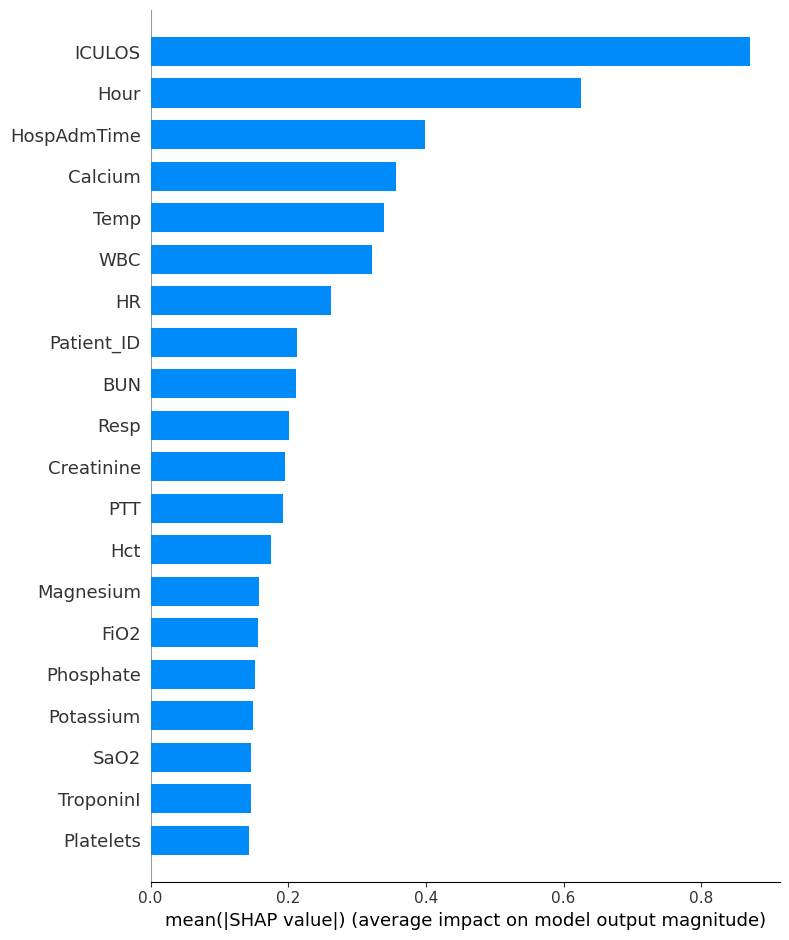

In [106]:
# Affichage du résultat de SHAP
explain_model_predictions_with_shap(xgbc_model, X_train, X_test)